## Table of Contents
- 1. Read and preprocess data
    - 1.1. GSE2034
    - 1.2. Selected
    - 1.3. Important values 
        - 1.3.1. Node genes- all genes of each node
        - 1.3.2. Expression values
        - 1.3.3. P-value and threshold <= 0.05 (gene is significant)
        - 1.3.4. Fold Change and Log Fold Change
        - 1.3.5. Extract the DataFrame for future use and create dictionaries for sub-paths based on the previous implemented functions
        - 1.3.6. Z-Score > 1.96 (gene is significant)
- 2. Methods
    - 2.1. MinePath - Completed
    - 2.2. TAPPA - Completed
    - 2.3. GraphiteWeb
    - 2.4. TEAK - Completed
    - 2.5. DEAP
    - 2.6. PRS - Completed
    - 2.7. HiPathia - Completed
    - 2.8. SPIA
- 3. Machine Learning
    - 3.1. Decision Trees
        - 3.1.1. Accuracy
        - 3.1.2. Feature Importance

In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
# For examples
path_no=0
sample_no=0

# 1. Read data and make them easier to understand

## 1.1. GSE2034

In [3]:
raw_gse2034_df = pd.read_csv('Data/GSE2034.zip', compression='zip', header=0, sep='\t', quotechar='"') # Breast cancer
gse2034_df=raw_gse2034_df.copy()

# preprocess dataset
gse2034_df[['Gene','KEGG-ID']] = gse2034_df['Class'].str.split('#',expand=True)
gse2034_df.drop('Class', inplace=True, axis=1)
cols = gse2034_df.columns.tolist()
cols = cols[-2:] + cols[:-2]
gse2034_df=gse2034_df[cols]

#gse2034_df

In [4]:
# Change column names (estrogen receptor)
labels=gse2034_df.columns[2:]
for x in range(len(labels)):
    if(labels[x].startswith('ERpos')):
        labels.values[x]="ERpos"
    elif(labels[x].startswith('ERneg')):
        labels.values[x]="ERneg"

In [5]:
# Get the genes that are present in the GSE2034 dataset and create a dictionary 
# where the keys are the genes and the values are the corresponding KEGG-IDs
# 'a gene can be mapped to more than one Entrez identifier'
gene_list=sorted(set(gse2034_df['Gene'].tolist()))
gene_dict={}
for i in gene_list:
    tmp=(gse2034_df.loc[gse2034_df['Gene'] == i]['KEGG-ID']).copy()
    tmp_list=[]
    for t in tmp:
        tmp_list.append(t)
    gene_dict.update({i:tmp_list})
#print('Gene dictionary (key: Genes, values: KEGG-IDs): '+str(gene_dict))

In [6]:
# transpose dataframe so that the columns indicate the genes
# and rows correspond to samples (class: ERpos or ERneg)
genes=(gse2034_df['Gene']).copy()
gse2034_df.drop('KEGG-ID', inplace=True, axis=1)
gse2034_df=np.transpose(gse2034_df.iloc[:,1:])
gse2034_df.columns=genes.values.tolist()
#gse2034_df

In [7]:
# Because one gene might correspond to more than one KEGG-IDs, we calculate the average (or max)
# value and get the following simplified dataframe
gse2034_df=gse2034_df.groupby(level=0,axis=1).mean()
gse2034_df['noProbe']=gse2034_df.mean(axis=1) # Compute 'noProbe' for future use
genes=gse2034_df.columns
gse2034_df

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,AFFX-HSAC07/X00351_M_at,AFFX-HUMGAPDH/M33197_3_at,AFFX-HUMGAPDH/M33197_5_at,AFFX-HUMGAPDH/M33197_M_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMISGF3A/M97935_5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMRGE/M10098_5_at,noProbe
ERpos,3848.1,228.9,213.1,1009.4,31.8,551.5,176.7,11.9,309.3,49.9,...,18021.8,19418.9,7449.3,14027.7,2908.8,29.8,403.9,389.9,802.5,951.084183
ERpos,6520.9,112.5,189.8,2083.3,145.8,802.8,278.4,28.3,449.0,122.9,...,1413.2,19474.9,408.7,2021.0,6087.7,16.1,79.3,274.5,247.8,1003.982691
ERpos,5285.7,178.4,269.7,1203.4,42.5,557.5,183.3,56.4,101.9,85.9,...,11882.3,26784.7,9109.6,20412.1,4264.5,96.3,837.3,937.3,2297.5,1034.462272
ERneg,4043.7,398.7,312.4,1104.4,108.2,568.5,187.7,42.1,899.1,90.7,...,38913.5,23342.8,9439.4,18474.2,3496.5,71.1,1024.2,982.5,807.1,1069.874739
ERpos,4263.6,417.7,327.1,1043.3,69.2,653.2,185.8,21.8,3629.3,96.0,...,30323.1,29313.6,8671.0,22684.5,3952.3,36.6,969.1,656.3,141.4,1017.023462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERpos,3066.9,265.5,347.9,1127.4,47.0,583.9,138.2,16.1,577.3,44.7,...,12251.5,24463.5,5378.0,14403.8,3991.3,46.7,399.2,329.5,413.1,1009.287513
ERpos,2773.0,209.8,226.7,1071.8,45.1,859.9,121.0,24.8,935.6,78.8,...,13415.3,14976.3,1593.7,5722.3,1361.4,11.1,143.1,281.9,231.2,1001.443436
ERpos,2984.3,160.0,252.9,1178.5,146.3,664.2,183.3,49.6,443.5,74.0,...,11946.3,22092.0,3503.0,9549.3,1917.7,33.1,119.7,295.9,269.2,1064.410080
ERneg,3540.0,285.7,135.1,1256.7,75.9,603.1,125.0,72.9,73.5,126.1,...,22759.9,15283.2,6157.2,12799.3,1880.2,8.4,533.8,491.1,113.0,1030.942125


## 1.2. Selected
Cellular processes (15), Signal transduction (Environmental information process) (24), Cancer overview (8).

In [8]:
raw_selected_df = pd.read_csv('Data/Selected.zip', compression='zip', header=0, sep='\t', quotechar='"')[['SubPathID']]
#raw_selected_df

In [9]:
# Two types of nodes relations
relations_dict={'Activation':'-->','Inhibition':'--|'}
#relations_dict

In [10]:
from itertools import chain

# Split each pathway based on the relation
def split_path(data,relation):
    s=[]
    cnt=len(data.split(relations_dict[relation]))
    cnt_tmp=1
    # If there is at least one relation, then split data
    if(cnt>0):
        for e in data.split(relations_dict[relation]):
            if e:
                s.append(e)
                # Remove the final relation
                if(cnt_tmp<cnt):
                    s.append(relations_dict[relation])
                cnt_tmp+=1
    return s

# Make the selected dataset easier to understand, by splitting each pathway based on their nodes and edges
def get_pathway(data):
    s=split_path(data,'Activation')

    for i in range(len(s)):
        tmp_s=split_path(s[i],'Inhibition')
        if(len(s[i])>1):
            s[i]=tmp_s
            
    return list(chain.from_iterable(s))

subpaths_list=[get_pathway(row) for row in raw_selected_df['SubPathID']]
#subpaths_list

In [11]:
selected_df=pd.DataFrame(subpaths_list).fillna(value=np.nan) # Rows: pathways, Cols: edges and nodes
selected_df

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
0,208200_at#hsa:3552 210118_s_at#hsa:3552 205067...,-->,202948_at#hsa:3554 215561_s_at#hsa:3554 205403...,-->,203901_at#hsa:10454,-->,206853_s_at#hsa:6885 206854_s_at#hsa:6885 2115...,-->,209666_s_at#hsa:1147 209341_s_at#hsa:3551 2093...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,208438_s_at#hsa:2268 208018_s_at#hsa:3055 2026...,-->,207821_s_at#hsa:5747 208820_at#hsa:5747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,207072_at#hsa:8807 206618_at#hsa:8809,-->,209239_at#hsa:4790 201783_s_at#hsa:5970 209878...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,206109_at#hsa:2523 208505_s_at#hsa:2524 210608...,-->,214088_s_at#hsa:2525 216010_x_at#hsa:2525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,213464_at#hsa:25759 noProbe#hsa:399694 206330_...,-->,215075_s_at#hsa:2885,-->,207112_s_at#hsa:2549 214987_at#hsa:2549,-->,220566_at#hsa:23533 204369_at#hsa:5290 212688_...,-->,212607_at#hsa:10000 212609_s_at#hsa:10000 2193...,--|,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41603,206890_at#hsa:3594,-->,206118_at#hsa:6775,-->,207849_at#hsa:3558,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41604,221271_at#hsa:59067,-->,219971_at#hsa:50615 221658_s_at#hsa:50615,-->,208991_at#hsa:6774 208992_s_at#hsa:6774,-->,210426_x_at#hsa:6095 210479_s_at#hsa:6095,-->,noProbe#hsa:112744 208402_at#hsa:3605 216876_s...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41605,219971_at#hsa:50615 221658_s_at#hsa:50615,-->,208991_at#hsa:6774 208992_s_at#hsa:6774,-->,210426_x_at#hsa:6095 210479_s_at#hsa:6095,-->,noProbe#hsa:112744 208402_at#hsa:3605 216876_s...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41606,216857_at#hsa:51561 217326_x_at#hsa:51561 2173...,-->,206890_at#hsa:3594,-->,208991_at#hsa:6774 208992_s_at#hsa:6774,-->,221271_at#hsa:59067,-->,219971_at#hsa:50615 221658_s_at#hsa:50615,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Two types of nodes relations
relations_dict={'Activation':'-->','Inhibition':'--|'}

## 1.3. Important values

### 1.3.1. Node genes- all genes of each node

In [125]:
# Each node in a pathway represents a discrete function mapping to one or more transcript.
# Returns a dictionary corresponding each node of each pathway to its gene or genes.
def Node_genes(df):
    Node_genes={}
    for path in range(df.shape[0]):
        tmp_node=[]
        for node in range(0,len(df.iloc[path][~df.iloc[path].isnull()]),2):
            genes=list(filter(None,[x.strip() for x in df.iloc[path,node].split(' ')]))
            tmp_genes=[]
            for g in genes:
                tmp_genes.append(list(filter(None,[x.strip() for x in g.split('#')]))[0])
            tmp_node.append(tmp_genes)
        Node_genes.update({path:tmp_node})
    return Node_genes

node_genes=Node_genes(selected_df)
#node_genes

### 1.3.2. Expression values
For each subpath assign each sample's genes expression values (3D: samples,subpaths,nodes)

In [14]:
from statistics import mean

# For a specific subpath match the expression values of each gene based on the values in a specific sample.
# In case of multiple genes in one node assign the average value.
def sample_expression_value(path,sample):
    sample_expr_val=[]
    for node in range(len(path)):
        node_genes=[]
        for gene in range(len(path[node])):
            node_genes.append(sample[gene])
        sample_expr_val.append(mean(node_genes)) # Calculate the average expression value of a node's genes
    return sample_expr_val

#sample_no=0
#path_no=0
#sample_expression_value(node_genes[path_no],gse2034_df.iloc[sample_no])

In [15]:
# For a specific subpath assign the expression values based on each sample and return a 2D array
def subpath_expression_value(path,samples):
    
    # Create a 2D array, where rows are the sample size and columns are the subpath's nodes
    subpath_expr_val=[]
    
    # For each sample
    for sample in range(samples.shape[0]):
        subpath_expr_val.append(sample_expression_value(path,samples.iloc[sample]))
        
    return subpath_expr_val

#subpath_expr_val=subpath_expression_value(node_genes[path_no],gse2034_df)
#subpath_expr_val

### 1.3.3. P-value and threshold <= 0.05 (gene is significant)
For each gene find the p-value (ttest_ind)

In [16]:
import scipy.stats as stats

#gse2034_data_df=gse2034_df.copy().T # Columns: samples and rows: genes
#gse2034_data_df

In [17]:
#gse2034_data_df['ERnegMean']=gse2034_data_df['ERneg'].mean(axis=1)
#gse2034_data_df['ERposMean']=gse2034_data_df['ERpos'].mean(axis=1)
#gse2034_data_df['Diffs']=gse2034_data_df['ERnegMean']-gse2034_data_df['ERposMean']
#gse2034_data_df

In [18]:
def pvalue005(genes):
    pvalArray=np.empty(genes.shape[0])
    pvalArrayUnder005=np.array([])
    indices005=np.array([])
    for x in range(genes.shape[0]):
        st,pval=stats.ttest_ind(genes['ERneg'].iloc[x],genes['ERpos'].iloc[x])
        pvalArray[x]=pval
        if(pval<0.05):
            pvalArrayUnder005=np.append(pvalArrayUnder005,pval)
            indices005=np.append(indices005,x)
    return pvalArray,pvalArrayUnder005,indices005

#pvalList2,pvalListUnder005_2,indices005_2=pvalue005(gse2034_data_df)

In [19]:
#gse2034_data_df['P-Value']=pvalList2
#gse2034_data_df

In [20]:
# For each node of a sub-path consisting of more than one genes, get the average value of the p-values.
def path_pvalue(path,df):
    cur_path=[]
    for node in path:
        cur_node=[]
        for gene in node:
            # Check if gene is not in genes' list
            if(not(gene in df.index)):
                cur_node.append(df.loc['noProbe']['P-Value'])
                continue
            cur_node.append(df.loc[gene]['P-Value'])
        cur_path.append(np.mean(cur_node))
    return cur_path
         
def get_pvalues(node_genes,df):
    pvalues={}
    for path in node_genes:
        pvalues.update({path:path_pvalue(node_genes[path],df)})  
    return pvalues

pvalue_threshold=0.05

#pvalues_dict=get_pvalues(node_genes,gse2034_data_df) # All sub-paths
#pvalues_dict

#pvalues=path_pvalue(node_genes[path_no],gse2034_data_df) # One sub-path
#pvalues

### 1.3.4. Fold Change and Log Fold Change
Add fold change column to genes_df

In [21]:
# Calculate fold change for each gene
def fold_change(df):
    fc_dict={}
    
    for gene in df.index:
        # Get average value for each case
        erneg_av=df.loc[gene]['ERneg'].mean()
        erpos_av=df.loc[gene]['ERpos'].mean()
        
        # Calculate fold change (B/A)
        cur_fc=erneg_av/erpos_av
        fc_dict.update({gene:cur_fc})
        
    return fc_dict        

#fc=fold_change(gse2034_data_df)
#gse2034_data_df['Fold Change']=fold_change(gse2034_data_df).values()
#gse2034_data_df['Log FC']=[math.log(fc+1-min(gse2034_data_df['Fold Change'])) for fc in gse2034_data_df['Fold Change']] # Calculate log fold change
#gse2034_data_df

In [22]:
# For each node of a sub-path consisting of more than one genes, get the average value of the fold change.
def path_fc(path,df):
    fc=[]
    log_fc=[]
    for node in path:
        cur_fc=[]
        cur_log_fc=[]
        for gene in node:
            # Check if gene is not in genes' list
            if(not(gene in df.index)):
                cur_fc.append(df.loc['noProbe']['Fold Change'])
                cur_log_fc.append(df.loc['noProbe']['Log FC'])
                continue
            cur_fc.append(df.loc[gene]['Fold Change'])
            cur_log_fc.append(df.loc[gene]['Log FC'])
        fc.append(np.mean(cur_fc))
        log_fc.append(np.mean(cur_log_fc))
    return fc,log_fc
            

def get_fc(node_genes,df):
    fc={}
    log_fc={}
    for path in node_genes:
        cur_fc,cur_log_fc=path_fc(node_genes[path],df)
        fc.update({path:cur_fc})  
        log_fc.update({path:cur_log_fc})  
    return fc,log_fc

log_fc_threshold=1.5 

#fc_dict,log_fc_dict=get_fc(node_genes,gse2034_data_df) # Return fold change and log fold change in dictionary form for all sub-paths

#fc,log_fc=path_fc(node_genes[path_no],gse2034_data_df) # Specific sub-path

### 1.3.5. Extract the DataFrame for future use and create dictionaries for sub-paths based on the previous implemented functions
- Values from 1.3.3. to 1.3.4. are extracted to GSE2034_data.csv so they don't have to be calculated every time.
- Create the dictionaries for each subpath using the GSE2034_data file.

In [23]:
import zipfile

zf = zipfile.ZipFile('Data\GSE2034_data.zip') 
gse2034_data_df = pd.read_csv(zf.open('GSE2034_data.csv')).iloc[:,1:]
new_columns=list(gse2034_df.index)+list(gse2034_data_df.columns[-6:])
gse2034_data_df.columns=new_columns
gse2034_data_df.index=genes
gse2034_data_df

,ERpos,ERpos,ERpos,ERneg,ERpos,ERpos,ERpos,ERpos,ERpos,ERpos,...,ERpos,ERpos,ERneg,ERpos,ERnegMean,ERposMean,Diffs,P-Value,Fold Change,Log FC
1007_s_at,3848.100000,6520.900000,5285.700000,4043.700000,4263.600000,2949.800000,5498.900000,3863.100000,3370.400000,3991.900000,...,2773.000000,2984.30000,3540.000000,2620.000000,3494.429870,3803.309091,-308.879221,0.054720,0.918787,0.630717
1053_at,228.900000,112.500000,178.400000,398.700000,417.700000,221.200000,280.400000,198.200000,304.700000,198.200000,...,209.800000,160.00000,285.700000,180.500000,281.202597,215.970813,65.231784,0.000004,1.302040,0.816343
117_at,213.100000,189.800000,269.700000,312.400000,327.100000,225.000000,243.500000,244.400000,348.500000,185.300000,...,226.700000,252.90000,135.100000,191.800000,320.085714,238.386124,81.699590,0.001407,1.342720,0.834165
121_at,1009.400000,2083.300000,1203.400000,1104.400000,1043.300000,1117.600000,1085.400000,1423.100000,1196.400000,993.300000,...,1071.800000,1178.50000,1256.700000,1284.600000,1136.923377,1120.720096,16.203281,0.696752,1.014458,0.680380
1255_g_at,31.800000,145.800000,42.500000,108.200000,69.200000,47.400000,84.300000,102.000000,22.800000,86.300000,...,45.100000,146.30000,75.900000,87.400000,62.942857,62.083254,0.859604,0.842199,1.013846,0.680070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AFFX-HUMISGF3A/M97935_5_at,29.800000,16.100000,96.300000,71.100000,36.600000,26.100000,8.800000,64.700000,68.600000,24.200000,...,11.100000,33.10000,8.400000,12.000000,61.705195,47.977512,13.727683,0.069333,1.286127,0.809284
AFFX-HUMISGF3A/M97935_MA_at,403.900000,79.300000,837.300000,1024.200000,969.100000,205.400000,388.200000,423.000000,380.700000,117.900000,...,143.100000,119.70000,533.800000,172.400000,557.687013,415.619139,142.067874,0.016618,1.341822,0.833775
AFFX-HUMISGF3A/M97935_MB_at,389.900000,274.500000,937.300000,982.500000,656.300000,371.900000,283.100000,765.200000,555.000000,195.600000,...,281.900000,295.90000,491.100000,150.000000,490.109091,397.902392,92.206699,0.041177,1.231732,0.784770
AFFX-HUMRGE/M10098_5_at,802.500000,247.800000,2297.500000,807.100000,141.400000,269.300000,93.600000,238.100000,427.800000,101.800000,...,231.200000,269.20000,113.000000,298.000000,634.938961,492.809091,142.129870,0.005809,1.288408,0.810298


#### 1.3.5.1. P-Value corresponding to each path's nodes 

In [137]:
pvalues=path_pvalue(node_genes[path_no],gse2034_data_df) # Specific sub-path
#pvalues

In [138]:
pvalues_dict=get_pvalues(node_genes,gse2034_data_df) # All sub-paths
#pvalues_dict

#### 1.3.5.2. Fold-Change and Log fold-Change corresponding to each path's nodes

In [26]:
fc,log_fc=path_fc(node_genes[path_no],gse2034_data_df) # Specific sub-path

In [27]:
fc_dict,log_fc_dict=get_fc(node_genes,gse2034_data_df) # Return fold change and log fold change in dictionary form for all sub-paths

### 1.3.6. Z-Score

In [28]:
# Calculate for each gene and sample the z-score and determine the threshold.

import scipy.stats as stats
z_threshold=1.96
z_score_df=pd.DataFrame(stats.zscore(gse2034_df, axis=1))
z_score_df.columns=gse2034_df.columns
z_score_df.index=gse2034_df.index
z_score_df

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,AFFX-HSAC07/X00351_M_at,AFFX-HUMGAPDH/M33197_3_at,AFFX-HUMGAPDH/M33197_5_at,AFFX-HUMGAPDH/M33197_M_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMISGF3A/M97935_5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMRGE/M10098_5_at,noProbe
ERpos,1.050309,-0.261827,-0.267555,0.021142,-0.333285,-0.144869,-0.280752,-0.340500,-0.232678,-0.326723,...,6.188965,6.695481,2.355919,4.740909,0.709767,-0.334010,-0.198381,-0.203457,-0.053869,0.000000e+00
ERpos,1.637154,-0.264549,-0.241610,0.320289,-0.254667,-0.059701,-0.215318,-0.289535,-0.164692,-0.261463,...,0.121436,5.481275,-0.176651,0.301802,1.508601,-0.293156,-0.274401,-0.216475,-0.224398,3.373676e-17
ERpos,1.207001,-0.243051,-0.217130,0.047964,-0.281636,-0.135418,-0.241660,-0.277689,-0.264771,-0.269314,...,3.079893,7.310947,2.292674,5.501654,0.917065,-0.266361,-0.055978,-0.027586,0.358599,0.000000e+00
ERneg,0.763432,-0.172302,-0.194457,0.008863,-0.246878,-0.128711,-0.226469,-0.263847,-0.043841,-0.251371,...,9.715102,5.717839,2.148599,4.467986,0.622956,-0.256402,-0.011725,-0.022431,-0.067459,0.000000e+00
ERpos,0.912558,-0.168460,-0.193926,0.007386,-0.266417,-0.102265,-0.233643,-0.279740,0.734267,-0.258884,...,8.237441,7.953688,2.151403,6.090360,0.825056,-0.275580,-0.013470,-0.101393,-0.246123,-3.195544e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERpos,0.636251,-0.229992,-0.204513,0.036523,-0.297557,-0.131537,-0.269356,-0.307111,-0.133578,-0.298268,...,3.476294,7.252464,1.350884,4.141824,0.922092,-0.297649,-0.188650,-0.210203,-0.184352,0.000000e+00
ERpos,0.548522,-0.245114,-0.239881,0.021784,-0.296110,-0.043826,-0.272609,-0.302395,-0.020387,-0.285675,...,3.843665,4.326993,0.183379,1.461705,0.111452,-0.306637,-0.265766,-0.222790,-0.238488,0.000000e+00
ERpos,0.486420,-0.229140,-0.205603,0.028906,-0.232611,-0.101396,-0.223236,-0.257110,-0.157313,-0.250928,...,2.757015,5.327510,0.617836,2.149715,0.216188,-0.261291,-0.239350,-0.194708,-0.201473,0.000000e+00
ERneg,0.720614,-0.214037,-0.257290,0.064839,-0.274293,-0.122878,-0.260191,-0.275155,-0.274982,-0.259875,...,6.240666,4.093320,1.472287,3.379932,0.243911,-0.293679,-0.142782,-0.155045,-0.263638,-6.530287e-17


# 2. Methods
## 2.1. MinePath
### 2.1.1. Discretization of gene expression values
Transform gene expression values into high (expressed / up-regulated) or low (not-expressed / down-regulated) gene expression binary equivalents
#### 2.1.1.1. The midpoints between each two consecutive values are calculated;

In [29]:
def midpoint(num1,num2):
    return (num1+num2)/2

# Returns the midpoints for a specific gene
def gene_midpoints(gene):
    tmp_gene=gene.copy()
    tmp_gene=tmp_gene.reset_index().drop(['index'],axis=1) # Keep previous positions
    
    # The expression values of a gene over the total number of input samples are sorted in descending order;
    sorted_gene=(tmp_gene/tmp_gene.shape[0]).sort_values(by=gene.name,ascending=False)
    
    midpoints_dict={}
    for i in range(sorted_gene.shape[0]-1):
        midpoints_dict.update({sorted_gene.index[i]:midpoint(sorted_gene.iloc[i][gene.name],sorted_gene.iloc[i+1][gene.name])})
    return midpoints_dict

#### 2.1.1.2. For each midpoint, μi, the Information Gain (IG) of the system is computed. Let IG(S,μi) to denote the IG of the system for midpoint μi.

In [30]:
import math 

# Calculate the proportion of samples in S that belong in Class C (ERneg, ERpos)
def P(C,S):
    return list(S).count(C)/len(S)

def E(S,classes,m=1):
    # m not given: calculate the entropy of the system taking into account the prior assignment of sample cases into phenotype classes
    # m given: calculate the respective entropy of the system taking into account its division into subgroups around midpoint μi
    tmp=0
    for c in classes:
        # P(c,S) must be greater than zero
        tmp+=P(c,S)*math.log(P(c,S))/m
    return -(tmp)

# Calculate the Information Gain (IG) of the system
def gene_IG(gene,midpoints):
    classes=sorted(set(gene.index))
    S=gene.index # the samples class
    
    information_gain={}
    for m in midpoints:
        information_gain.update({m:E(S,classes)-E(S,classes,midpoints[m])})
    
    return information_gain

#### 2.1.1.3. The sample cases with expression values lower than the discretization point are assigned the '0' value (meaning that the gene is under-expressed), and the sample cases with expression values bigger that the discretization point are assigned the '1' value (the gene is over-expressed).
The discretization process is applied for each gene separately, and the final dataset is a matrix of discretized, actually binarized, values.

In [31]:
def discretization_point(gene):
    midpoints=gene_midpoints(gene)
    information_gain=gene_IG(gene,midpoints)
    
    # The midpoint with the highest information gain is selected as the discretization point
    max_value=max(information_gain.values())
    max_mid_pos = max(information_gain, key=information_gain.get)
    dis_point=midpoints.get(max_mid_pos)
    return dis_point

def gene_discretization(gene):
    dis_point=discretization_point(gene)
    
    gene_dis=gene.copy()
    gene_dis[gene_dis<dis_point]=0 # under-expressed
    gene_dis[gene_dis>=dis_point]=1 # over-expressed
    gene_dis=gene_dis.astype('int')
    
    return gene_dis

def discretization(genes):
    dis_genes={}
    for gene in genes.columns:
        dis_genes.update({gene:list(gene_discretization(genes[gene]))})
    return dis_genes

In [32]:
for i in gene_discretization(gse2034_df['noProbe']):
    if(i!=1):
        print('yes')

In [33]:
# Compute discretized gene expression values
#dis_gse2034_df=pd.DataFrame(discretization(gse2034_df),index=gse2034_df.index)
#dis_gse2034_df.to_csv('Data/MinePath_discr_data.csv',index=False)
dis_gse2034_df=pd.read_csv ('Data/MinePath_discr_data.csv')
dis_gse2034_df.index=gse2034_df.index
dis_gse2034_df

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,AFFX-HSAC07/X00351_M_at,AFFX-HUMGAPDH/M33197_3_at,AFFX-HUMGAPDH/M33197_5_at,AFFX-HUMGAPDH/M33197_M_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMISGF3A/M97935_5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMRGE/M10098_5_at,noProbe
ERpos,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ERpos,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ERpos,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ERneg,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ERpos,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERpos,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ERpos,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ERpos,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ERneg,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


### 2.1.2. Functional sub-paths: Matching sub-paths with gene expression profiles
Due to the large volume of data, we refer only to one patient and in the future we will apply the analysis to the rest

In [34]:
# The following functions compute the 'and' and 'xor' boolean operations (activation and inhibition)
def and_boolean_op(num1,num2):
    return num1*num2
    
def xor_boolean_op(num1,num2):
    return 1 if(num1 and not num2) or (not num1 and num2) else 0

def or_boolean_op(num1,num2):
    return 0 if(not num1 and not num2) else 1

In [35]:
import statistics

# Get the nodes of a specific sub-path and sample in binary form
def sample_functional_subpath(sample,path):
    expr_prof=[]
    for node in path:
        tmp_node=[]
        for gene in node:
            if(not(gene in sample.index)):
                gene='noProbe'
            tmp_node.append(sample[gene])
            
        # Calculate one value for each node using the OR boolean operator
        tmp_or=0
        for v in tmp_node:
            tmp_or=or_boolean_op(tmp_or,v)
        
        expr_prof.append(tmp_or)
    return expr_prof

#tmp_funct_subpath=sample_functional_subpath(dis_gse2034_df.iloc[0],node_genes[0])

In [36]:
# Calculate the pathway expression of a specific sample and sub-path with boolean operations
def calc_pathway_expression(path,edges,prev_result):
    operations_dict={'Activation':and_boolean_op,'Inhibition':xor_boolean_op}
    
    # Two types of nodes relations
    relations_dict={'Activation':'-->','Inhibition':'--|'}
    
    if(len(path)>1):
        relation=list(relations_dict.keys())[list(relations_dict.values()).index(edges[0])] # Get the current edge type
        next_node=path[1]
        result=operations_dict[relation](prev_result,next_node)
        return calc_pathway_expression(path[1:],edges[1:],result)
    
    return prev_result

# Calculate a specific sub-path's expression for each sample with boolean operations
def calc_all_samples_expression(path,edges,samples):
    subpath_expr=[]
    for sample in range(samples.shape[0]):
        funct_subpath=sample_functional_subpath(samples.iloc[sample],path)
        subpath_expr.append(calc_pathway_expression(funct_subpath,edges,funct_subpath[0]))
    return subpath_expr

In [37]:
# For a specific sub-path and each sample calculate the sub-path's expression 
# Rows: samples, column: pathway #0
'''
path_no=0
path=node_genes[path_no]
edges=list(selected_df.iloc[path_no][~selected_df.iloc[path_no].isnull()][1::2])
subpath_0_expression=calc_all_samples_expression(path,edges,dis_gse2034_df)
    
print('Expression of sub-path #%d : %s'%(path_no,subpath_0_expression))
'''

"\npath_no=0\npath=node_genes[path_no]\nedges=list(selected_df.iloc[path_no][~selected_df.iloc[path_no].isnull()][1::2])\nsubpath_0_expression=calc_all_samples_expression(path,edges,dis_gse2034_df)\n    \nprint('Expression of sub-path #%d : %s'%(path_no,subpath_0_expression))\n"

### 2.1.3. Compute each sub-path's score for each sample and create the final DataFrame
Because of the computational time, each time the score of 5% of sub-paths is computed and appended in a DataFrame. The next 5% is used etc.
The first 5% of sub-paths is already calculated

In [38]:
# Each 5% of the pathways' score computed is appended to the previously created DataFrame.
def minepath_5(selected_df,node_genes,dis_gse2034_df,already_calculated,percentage=0.05):
    print(already_calculated)
    
    start=already_calculated*int(selected_df.shape[0]*0.05)
    end=start+int(selected_df.shape[0]*0.05)
    
    if(end>selected_df.shape[0]):
        end=selected_df.shape[0]
    
    new_cols=list(range(start,end))
    
    minepath_scores=[] # Row: sub-path, columns: samples
    i=1
    for path in range(start,end): # The score of 5% of all sub-paths is computed, because of the computational time
        print(i*100/int(selected_df.shape[0]*0.05))
        i+=1
        edges=list(selected_df.iloc[path][~selected_df.iloc[path].isnull()][1::2])
        minepath_scores.append(calc_all_samples_expression(node_genes[path],edges,dis_gse2034_df))
    
    if(already_calculated):
        prev_minepath_df = pd.read_csv ('Results/MinePath.csv')
        prev_minepath_df.index=gse2034_df.index

        tmp_minepath_df=pd.DataFrame(np.array(minepath_scores).T, columns=new_cols)
        tmp_minepath_df.index=gse2034_df.index

        new_minepath_df=pd.concat([prev_minepath_df, tmp_minepath_df], axis=1)
        new_minepath_df.to_csv('Results/MinePath.csv',index=False) # Already computed
    else:
        tmp_minepath_df=pd.DataFrame(np.array(minepath_scores).T,columns=new_cols)
        tmp_minepath_df.to_csv('Results/MinePath.csv',index=False)
    print('---------------')
'''    
percentage=0.05
times=int(1/percentage)
for t in range(times+1):
    minepath_5(selected_df,node_genes,dis_gse2034_df,t)
'''

'    \npercentage=0.05\ntimes=int(1/percentage)\nfor t in range(times+1):\n    minepath_5(selected_df,node_genes,dis_gse2034_df,t)\n'

In [111]:
'''
minepath_df = pd.read_csv ('Results/MinePath.csv')
minepath_df.index=gse2034_df.index
'''

zf = zipfile.ZipFile('Results/MinePath.zip') 
minepath_df = pd.read_csv(zf.open('MinePath.csv'))
minepath_df.index=gse2034_df.index
minepath_df
minepath_df

,0,1,2,3,4,5,6,7,8,9,...,41598,41599,41600,41601,41602,41603,41604,41605,41606,41607
ERpos,1,1,1,1,0,1,0,1,0,1,...,1,1,1,1,1,1,1,1,1,1
ERpos,1,1,1,1,0,1,0,1,0,1,...,1,1,1,1,1,1,1,1,1,1
ERpos,1,1,1,1,0,1,0,1,0,1,...,1,1,1,1,1,1,1,1,1,1
ERneg,1,1,1,1,0,1,0,1,0,1,...,1,1,1,1,1,1,1,1,1,1
ERpos,1,1,1,1,0,1,0,1,0,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERpos,1,1,1,1,0,1,0,1,0,1,...,1,1,1,1,1,1,1,1,1,1
ERpos,1,1,1,1,0,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ERpos,1,1,1,1,0,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ERneg,1,1,1,1,0,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1


## 2.2. TAPPA

### 2.2.1. Adjacency matrix

In [40]:
# The adjacency matrix is defined as A=(a_ij), where a_ij=1 if i=j or (g_i, g_j) belongs to E and a_ij=0 if (g_i, g_j) does 
# not belong to E.
def path_adjacency_matrix(nodes):
    tmp_adj=[]
    
    #i=j -> a_ij=1
    for i in range(len(nodes)):
        tmp_adj.append([0]*len(nodes))
        for j in range(len(nodes)):
            if(i==j):
                tmp_adj[i][j]=1
                continue
                
    # (g_i,g_j) belongs to E (current sub-paths are linear) -> a_ij=1          
    for i in range(len(nodes)-1):
        tmp_adj[i][i+1]=1
        tmp_adj[i+1][i]=1
            
    return tmp_adj

# Returns the adjacency matrices of each sub-path
def adjacency_matrix(paths):
    adj_matrices={}
    for path in paths:
        adj_matrices.update({path:path_adjacency_matrix(paths[path])})
    return adj_matrices

#### 2.2.1.2. Define PCI
Assuming that x_is is the normalized log expression measurement for gene i in sample s.

In [41]:
def sigmoid_normalization(df):
    # Each column expression values are normalized to zero mean [x_is=(x_is^orig-mean(x_is^orig))/σ_s].
    tmp_df=df.copy()
    tmp_df=(tmp_df-tmp_df.mean())/tmp_df.std()

    # Further normalize to (-0.5,0.5) with Sigmoid function (Sigmoid (x_is) - 0.5) to lower the effects of extremely large/small 
    # values for gene i in sample s.
    x={}
    for gene in tmp_df.columns:
        tmp_gene=[]
        for sample in range(tmp_df.shape[0]):
            tmp_gene.append((1 / (1 + math.exp(-df[gene].iloc[sample]))-0.5))
        x.update({gene:tmp_gene})
    return x

#gene_expression_df=pd.DataFrame(sigmoid_normalization(gse2034_df),index=gse2034_df.index)

In [42]:
from statistics import mean

# Define x for a specific sub-path and sample
def sample_x(path,sample):
    x=[]
    for node in path:
        cur_node=[]
        for gene in node:
            if(not(gene in sample.index)):
                cur_node.append(sample['noProbe'])
                continue
            cur_node.append(sample[gene])
        #Each node consists of one or more genes, so each node gets the average value.
        x.append(mean(cur_node))
    return x

# Define x for a specific sub-path and each sample
def get_x(path,samples):
    x=[]
    for sample in range(samples.shape[0]):
        x.append(sample_x(path,samples.iloc[sample]))
    return x
        
# Node_genes is initialized 
#x=get_x(node_genes[path_no],gene_expression_df)

In [43]:
def path_PCI(path,x,a):
    # Number of genes (ignore the edges)
    N=len(path)
    pci=0
    for i in range(N):
        for j in range(N):
            pci+=np.sign(x[i]+x[j])*(abs(x[i])**0.5)*a[i][j]*(abs(x[j])**0.5)
    return pci

# Calculate PCI for a specific sub-path and each sample
def PCI(path,x,a):
    pci=[]
    for sample in range(len(x)):
        pci.append(path_PCI(path,x[sample],a))
    return pci

#pci=PCI(node_genes[path_no],x,path_adjacency_matrix(node_genes[path_no]))

### 2.2.2. Normalize PCI (divided by the gene number in pathway)

In [44]:
def normalize_PCI(pci,path):
    norm_pci=[]
    for sample in range(len(pci)):
        cur_len=len(path)
        norm_pci.append(pci[sample]/cur_len)
    return norm_pci

#norm_pci=normalize_PCI(pci,node_genes[path_no])
#tappa_df=pd.DataFrame(norm_pci,columns=[path_no])

### 2.2.3. Compute each sub-path's score for each sample and create the final DataFrame
Because of the computational time, each time the score of 5% of sub-paths is computed and appended in a DataFrame. The next 5% is used etc. The first 5% of sub-paths is already calculated

In [45]:
# Each 5% of the pathways' score computed is appended to the previously created DataFrame.
def tappa_5(gene_expression_df,node_genes,already_calculated,percentage=0.05):
    print(already_calculated)
    
    start=already_calculated*int(selected_df.shape[0]*0.05)
    end=start+int(selected_df.shape[0]*0.05)
    
    if(end>selected_df.shape[0]):
        end=selected_df.shape[0]
    
    new_cols=list(range(start,end))
    
    tappa_scores=[] # Row: sub-path, columns: samples
    i=1
    for path in range(start,end): # The score of 5% of all sub-paths is computed, because of the computational time
        print(i*100/int(selected_df.shape[0]*0.05))
        i+=1
        x=get_x(node_genes[path],gene_expression_df)
        pci=PCI(node_genes[path],x,path_adjacency_matrix(node_genes[path]))
        tappa_scores.append(normalize_PCI(pci,node_genes[path]))
    
    if(already_calculated):
        prev_tappa_df = pd.read_csv ('Results/TAPPA.csv')
        prev_tappa_df.index=gse2034_df.index

        tmp_tappa_df=pd.DataFrame(np.array(tappa_scores).T, columns=new_cols)
        tmp_tappa_df.index=gse2034_df.index

        new_tappa_df=pd.concat([prev_tappa_df, tmp_tappa_df], axis=1)
        new_tappa_df.to_csv('Results/TAPPA.csv',index=False) # Already computed
    else:
        tmp_tappa_df=pd.DataFrame(np.array(tappa_scores).T,columns=new_cols)
        tmp_tappa_df.to_csv('Results/TAPPA.csv',index=False)
    print('---------------')

'''
percentage=0.05
times=int(1/percentage)
gene_expression_df=pd.DataFrame(sigmoid_normalization(gse2034_df),index=gse2034_df.index)
for t in range(times+1):
    tappa_5(gene_expression_df,node_genes,t)
'''

'\npercentage=0.05\ntimes=int(1/percentage)\ngene_expression_df=pd.DataFrame(sigmoid_normalization(gse2034_df),index=gse2034_df.index)\nfor t in range(times+1):\n    tappa_5(gene_expression_df,node_genes,t)\n'

In [112]:
#tappa_df = pd.read_csv ('Results/TAPPA.csv')
#tappa_df.index=gse2034_df.index

zf = zipfile.ZipFile('Results/TAPPA.zip') 
tappa_df = pd.read_csv(zf.open('TAPPA.csv'))
tappa_df.index=gse2034_df.index
tappa_df

,0,1,2,3,4,5,6,7,8,9,...,41598,41599,41600,41601,41602,41603,41604,41605,41606,41607
ERpos,1.299999,1.000000,1.0,1.000000,1.333311,0.995378,1.299594,1.0,1.357114,0.999982,...,1.249998,1.000000,1.166667,1.166667,1.166667,1.166667,1.285316,1.231646,1.299998,1.300000
ERpos,1.299933,0.999999,1.0,1.000000,1.333333,0.999903,1.299978,1.0,1.352417,1.000000,...,1.250000,1.000000,1.166667,1.166667,1.166667,1.166639,1.297823,1.247279,1.300000,1.299984
ERpos,1.299922,1.000000,1.0,1.000000,1.333330,0.994309,1.299908,1.0,1.357131,0.999932,...,1.250000,1.000000,1.166667,1.166667,1.166667,1.166667,1.275282,1.219103,1.300000,1.300000
ERneg,1.300000,0.999989,1.0,1.000000,1.333333,0.999196,1.299957,1.0,1.356881,0.999975,...,1.250000,1.000000,1.166667,1.166667,1.166667,1.166667,1.290727,1.238409,1.300000,1.300000
ERpos,1.300000,0.999987,1.0,1.000000,1.333333,0.999762,1.299970,1.0,1.323597,0.999986,...,1.250000,1.000000,1.166667,1.166667,1.166667,1.166667,1.299555,1.249444,1.300000,1.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERpos,1.300000,0.999999,1.0,1.000000,1.333330,0.994713,1.299877,1.0,1.343148,0.998770,...,1.250000,1.000000,1.166667,1.166667,1.166667,1.165316,1.268490,1.210613,1.300000,1.299189
ERpos,1.298912,1.000000,1.0,1.000000,1.333299,0.994470,1.299977,1.0,1.356511,0.999972,...,1.250000,1.000000,1.166667,1.166667,1.166667,1.166667,1.299670,1.249588,1.300000,1.299999
ERpos,1.300000,0.999999,1.0,1.000000,1.333333,1.000000,1.299997,1.0,1.357143,0.999992,...,1.250000,1.000000,1.166667,1.166667,1.166667,1.166667,1.300000,1.250000,1.300000,1.300000
ERneg,1.300000,1.000000,1.0,0.999969,1.332002,0.999268,1.299939,1.0,1.357143,0.999797,...,1.250000,0.995027,1.166667,1.166667,1.166667,1.166667,1.280852,1.226065,1.300000,1.297000


## 2.3. GraphiteWeb- Enrichment analysis (competitive and non-topological)
### 2.3.1. Probability P
#### 2.3.1.1. Hypergeometric Distribution
https://towardsdatascience.com/hypergeometric-distribution-explained-with-python-2c80bc613bf4

In [47]:
from scipy.special import comb

def hypergeom_pmf(N, A, n, x):
    
    '''
    Probability Mass Function for Hypergeometric Distribution
    :param N: population size
    :param A: total number of desired items in N
    :param n: number of draws made from N
    :param x: number of desired items in our draw of n items
    :returns: PMF computed at x
    '''
    Achoosex = math.comb(A,x)
    NAchoosenx = math.comb(N-A, n-x)
    Nchoosen = math.comb(N,n)
    
    return (Achoosex)*NAchoosenx/Nchoosen

def hypergeom_cdf(N, A, n, t, min_value=None):
    
    '''
    Cumulative Density Funtion for Hypergeometric Distribution
    :param N: population size
    :param A: total number of desired items in N
    :param n: number of draws made from N
    :param t: number of desired items in our draw of n items up to t
    :returns: CDF computed up to t
    '''
    if min_value:
        return np.sum([hypergeom_pmf(N, A, n, x) for x in range(min_value, t+1)])
    
    return np.sum([hypergeom_pmf(N, A, n, x) for x in range(t+1)])

#### 2.3.1.2. Expression value of each gene and DEGs in every subpath

In [48]:
'''
def sample_genes_expr_values(path,sample):
    expr_vals=[]
    for node in range(len(path)):
        cur_n=[]
        for g in path[node]:
            if(not g in sample.index):
                g='noProbe'
            cur_n.append(sample[g])
        expr_vals.append(cur_n)
    return expr_vals

def genes_expr_values(path,samples):
    expr_vals=[]
    for sample in range(samples.shape[0]):
        expr_vals.append(sample_genes_expr_values(path,samples.iloc[sample]))
    return expr_vals
'''

"\ndef sample_genes_expr_values(path,sample):\n    expr_vals=[]\n    for node in range(len(path)):\n        cur_n=[]\n        for g in path[node]:\n            if(not g in sample.index):\n                g='noProbe'\n            cur_n.append(sample[g])\n        expr_vals.append(cur_n)\n    return expr_vals\n\ndef genes_expr_values(path,samples):\n    expr_vals=[]\n    for sample in range(samples.shape[0]):\n        expr_vals.append(sample_genes_expr_values(path,samples.iloc[sample]))\n    return expr_vals\n"

In [49]:
# Each node is assigned a value derived from expression data. The following values are assigned to the node: 0 if the 
# corresponding gene or genes are not expressed (z-score < 0), 1 if they are expressed but remain unchanged (z-score > 0 
# and z-score < threshold), or the maximum fold-change value if one or more of the mapped transcripts is above threshold
# (z-score > threshold).

def gene_status(z,threshold):
    if(z<0):
        return "not expressed"
    # Expressed (z-score > 0)
    if(z<threshold): # non-significant
        return "non-significant"
    else: # significant
        return "significant"

# Return the number of expressed genes and significant genes for a node in a specific sub-path with a specific sample's data
def node_status(node,z,threshold):
    status=[]
    for gene in node:
        if(not gene in z.index):
            status.append(gene_status(z['noProbe'],threshold))
            continue
        status.append(gene_status(z[gene],threshold))
    NDEGs=status.count('significant')
    NEGs=NDEGs+status.count('non-significant')
    return NEGs,NDEGs

In [50]:
# Number of DEGs in specific sub-path and sample
def sample_DEGs(path,z,threshold):
    degs=0
    for node in path:
        node_NEGs,node_NDEGs=node_status(node,z,threshold)
        degs+=node_NDEGs
    return degs

# Number of DEGs in specific sub-path and each sample
def DEGs(path,z,threshold):
    degs=[]
    for sample in range(z.shape[0]):
        degs.append(sample_DEGs(path,z.iloc[sample],threshold))
    return degs

#### 2.3.1.3. Calculate probability P
Two-way contigency table
DEG: differentially expressed genes
EEG: equally expressed genes (mean expression levels are the same across all replicates in two comparison groups)
N: total number of genes screened

In [51]:
# Calculate P for a specific sub-path and sample
def sample_P(path,z,threshold,N,N_deg,N_eeg):
    expr_val=[]
    
    # Total
    N_G=len(list(chain.from_iterable(path))) # Total number of genes in current subpath G
    N_CG=N-N_G # Total number of genes in the complement of G
    
    # DEG
    n_G_deg=sample_DEGs(path,z,threshold) # Number of DEGs in subpath
    n_CG_deg=N_deg-n_G_deg # Number of DEGs in the complement of G
    
    p = sum([hypergeom_cdf(N,N_deg,N_G,x,n_G_deg) for x in range(N_G+1)]) # N_G_deg>=n_G_deg
    return p

def P(path,z,threshold,N,N_deg,N_eeg):
    p=[]
    for sample in range(z.shape[0]):
        p.append(sample_P(path,z.iloc[sample],threshold,N,N_deg,N_eeg))
    return p

#N=gse2034_df.shape[1] # Total number of genes screened 
#N_deg=gse2034_data_df['P-Value'][gse2034_data_df['P-Value']<=pvalue_threshold].shape[0] # Total number of DEGs
#N_eeg= N-N_deg # The genes that are not differentially expressed

#p=P(node_genes[path_no],z_score_df,z_threshold,N,N_deg,N_eeg)

### 2.3.2. Compute each sub-path's score for each sample and create the final DataFrame
Because of the computational time, each time the score of 5% of sub-paths is computed and appended in a DataFrame. The next 5% is used etc. The first 5% of sub-paths is already calculated

In [52]:
from statsmodels.stats.multitest import multipletests

# Each 5% of the pathways' score computed is appended to the previously created DataFrame.
def graphiteweb_5(node_genes,z_score_df,z_threshold,N,N_deg,N_eeg,already_calculated,percentage=0.05):
    print(already_calculated)
    
    start=already_calculated*int(selected_df.shape[0]*0.05)
    end=start+int(selected_df.shape[0]*0.05)
    
    if(end>selected_df.shape[0]):
        end=selected_df.shape[0]
    
    new_cols=list(range(start,end))
    
    graphiteweb_scores=[] # Row: sub-path, columns: samples
    i=1
    for path in range(start,end): # The score of 5% of all sub-paths is computed, because of the computational time
        print(i*100/int(len(node_genes)*0.05))
        i+=1
        
        p=P(node_genes[path],z_score_df,z_threshold,N,N_deg,N_eeg)
        
        # Benjamini and Hochberg method: Ps adjustment
        adj_p=list(multipletests(pvals=p, alpha=0.05, method="fdr_bh")[1])
        
        graphiteweb_scores.append(adj_p)
    
    if(already_calculated):
        prev_graphiteweb_df = pd.read_csv ('Results/GraphiteWeb.csv')
        prev_graphiteweb_df.index=gse2034_df.index

        tmp_graphiteweb_df=pd.DataFrame(np.array(graphiteweb_scores).T, columns=new_cols)
        tmp_graphiteweb_df.index=gse2034_df.index

        new_graphiteweb_df=pd.concat([prev_graphiteweb_df, tmp_graphiteweb_df], axis=1)
        new_graphiteweb_df.to_csv('Results/GraphiteWeb.csv',index=False) # Already computed
    else:
        tmp_graphiteweb_df=pd.DataFrame(np.array(graphiteweb_scores).T,columns=new_cols)
        tmp_graphiteweb_df.to_csv('Results/GraphiteWeb.csv',index=False)
    print('---------------')

percentage=0.05
times=int(1/percentage)

N=gse2034_df.shape[1] # Total number of genes screened 
N_deg=gse2034_data_df['P-Value'][gse2034_data_df['P-Value']<=pvalue_threshold].shape[0] # Total number of DEGs
N_eeg=N-N_deg # The genes that are not differentially expressed (not needed): genes whose mean expression levels are the same across all replicates in two comparison groups

#for t in range(already_calculated,times+1):
#    graphiteweb_5(node_genes,z_score_df,z_threshold,N,N_deg,N_eeg,t)

In [113]:
#graphiteweb_df = pd.read_csv ('Results/GraphiteWeb.csv')
#graphiteweb_df.index=gse2034_df.index

zf = zipfile.ZipFile('Results/GraphiteWeb.zip') 
graphiteweb_df = pd.read_csv(zf.open('GraphiteWeb.csv'))
graphiteweb_df.index=gse2034_df.index
graphiteweb_df

,0,1,2,3,4,5,6,7,8,9,...,41598,41599,41600,41601,41602,41603,41604,41605,41606,41607
ERpos,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ERpos,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ERpos,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ERneg,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ERpos,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERpos,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ERpos,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ERpos,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ERneg,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## 2.4. TEAK
### 2.4.1. SubPathway Ranking
#### 2.4.1.1. Conditional Probability Distribution
- Node Y with m continuous parents X1,...,Xm
- β0, ... , βm are the regression coefficients
- σ^2 is the variance

In [54]:
# Regression coefficients (b1=Σ[(xi-x)(yi-y)]/Σ[(xi-x)], where x and y are the mean values of x and y respectively)
# Since our subpaths are linear, each node Y has one parent node x, and so only 2 coefficients (β0,β1).
def estimate_coef(x, y):
    # number of observations/points
    n = np.size(x)
  
    # mean of x and y vector
    m_x = np.mean(x)
    m_y = np.mean(y)
    
    if(n==1):
        # calculating cross-deviation and deviation about x
        SS_xy = (y*x)[0]
        SS_xx = (x*x)[0]
    else:
        # calculating cross-deviation and deviation about x
        SS_xy = sum(y*x) - n*m_y*m_x
        SS_xx = sum(x*x) - n*m_x*m_x
    
    # calculating regression coefficients
    if(SS_xx): # If SS_xx is not zero the proceed with the division
        b_1 = SS_xy / SS_xx
    else: 
        b_1=0
    b_0 = m_y - b_1*m_x
  
    return (b_0, b_1)

In [55]:
import statistics
import scipy.stats

# Calculate the Conditional Probability Distribution for a specific node and sub-path [p(Y|x1,...,xm)=N(β0+β1*x1+...+βm*xm;σ^2)]
def node_cond_prob_distr(node_no,expr_vals,reg_coef,variance):
    distr_mean=reg_coef[0]
    if(node_no==0): # If current node is root (without parents), then return β0
        return distr_mean
    distr_mean+=reg_coef[1]*expr_vals[node_no-1]
    
    distribution = scipy.stats.norm(loc=distr_mean,scale=variance)
    sample = distribution.rvs(size=1)[0] # linear networks: size=1

    return sample
    
# Calculate the Conditonal Probability Distribution for a specific sample and sub-path
def sample_cond_prob_distr(expr_vals):
    x = np.array(expr_vals[:-1]) # Continuous parents x1,...,xm
    y = np.array(expr_vals[1:]) # Continuous nodes Y
    reg_coef=estimate_coef(y,x)

    if(len(y)>1):
        variance=statistics.variance(y)
    else:
        variance=y[0]

    cond_prob=[]
    for node in range(len(expr_vals)):
        cond_prob.append(node_cond_prob_distr(node,expr_vals,reg_coef,variance))
    return cond_prob
    
# Calculate the Conditional Probability Distribution for a specific sub-path and each sample
def cond_prob_distr(expr_vals):
    cond_prob=[]
    for sample in range(len(expr_vals)):
        cond_prob.append(sample_cond_prob_distr(expr_vals[sample]))
    return cond_prob

#cond_prob=cond_prob_distr(subpath_expression_value(node_genes[path_no],gse2034_df))

#### 2.4.1.2.  Score_BIC=logP(D|θ)-0.5d*logN
- D: gene expression data
- θ: maximum likelihood estimate of the parameters used to represent the linear Gaussian node
- d: number of parameters
- N: number of samples in the gene expression data

In [56]:
# Get node's BIC score for a specific sub-path and sample
def node_score_BIC(cond_prob_distr,node_no,N):
    if(node_no==0):
        return math.log(cond_prob_distr[node_no]+1-min(cond_prob_distr)) # No parent node
    # Else: All other nodes have only 1 parent node (d=1)
    # Logarithm of negative values: Translate, then Transform (log(Y + 1 - min(Y)))
    # Source: https://blogs.sas.com/content/iml/2011/04/27/log-transformations-how-to-handle-negative-data-values.html
    score=math.log(cond_prob_distr[node_no]+1-min(cond_prob_distr))-0.5*math.log(N)
    return score

# Get BIC score for a specific sub-path and sample
def sample_score_BIC(cond_prob_distr,N):
    score=[]
    for node in range(len(cond_prob_distr)):
        score.append(node_score_BIC(cond_prob_distr,node,N))
        
    # Sum all nodes' scores and return final result, since BIC is decomposable.
    return sum(score)

# Get BIC score for a specific sub-path and each sample
def score_BIC(cond_prob,N):
    score=[]
    for sample in range(len(cond_prob)):
        score.append(sample_score_BIC(cond_prob[sample],N))
    return score
    
#bic=score_BIC(cond_prob,gse2034_df.shape[1])

#### 2.4.1.3. Normalize scores
The score for each subpathway is normalized by its number of nodes, so that the scores are comparable.

In [57]:
def get_normalized_scores(scores,path):
    normalized_scores=[]
    for sample in range(len(scores)):
        normalized_scores.append(scores[sample]/len(path))
    return normalized_scores

#norm_score_BIC=get_normalized_scores(bic,node_genes[path_no])

### 2.4.2. Compute each sub-path's score for each sample and create the final DataFrame
Because of the computational time, each time the score of 5% of sub-paths is computed and appended in a DataFrame. The next 5% is used etc. The first 5% of sub-paths is already calculated

In [58]:
# Each 5% of the pathways' score computed is appended to the previously created DataFrame.
def teak_5(node_genes,already_calculated,percentage=0.05):
    print(already_calculated)
    
    start=already_calculated*int(selected_df.shape[0]*0.05)
    end=start+int(selected_df.shape[0]*0.05)
    
    if(end>selected_df.shape[0]):
        end=selected_df.shape[0]
    
    new_cols=list(range(start,end))
    
    teak_scores=[] # Row: sub-path, columns: samples
    i=1
    for path in range(start,end): # The score of 5% of all sub-paths is computed, because of the computational time
        print(i*100/int(len(node_genes)*0.05))
        i+=1
        
        cond_prob=cond_prob_distr(subpath_expression_value(node_genes[path],gse2034_df))
        bic=score_BIC(cond_prob,gse2034_df.shape[1])
        norm_score_BIC=get_normalized_scores(bic,node_genes[path])
        teak_scores.append(norm_score_BIC)
    
    if(already_calculated):
        prev_teak_df = pd.read_csv ('Results/TEAK.csv')
        prev_teak_df.index=gse2034_df.index

        tmp_teak_df=pd.DataFrame(np.array(teak_scores).T, columns=new_cols)
        tmp_teak_df.index=gse2034_df.index

        new_teak_df=pd.concat([prev_teak_df, tmp_teak_df], axis=1)
        new_teak_df.to_csv('Results/TEAK.csv',index=False) # Already computed
    else:
        tmp_teak_df=pd.DataFrame(np.array(teak_scores).T,columns=new_cols)
        tmp_teak_df.to_csv('Results/TEAK.csv',index=False)
    print('---------------')

'''
percentage=0.05
times=int(1/percentage)

for t in range(times+1):
    teak_5(node_genes,t)
'''

'\npercentage=0.05\ntimes=int(1/percentage)\n\nfor t in range(times+1):\n    teak_5(node_genes,t)\n'

In [114]:
#teak_df = pd.read_csv ('Results/TEAK.csv')
#teak_df.index=gse2034_df.index

zf = zipfile.ZipFile('Results/TEAK.zip') 
teak_df = pd.read_csv(zf.open('TEAK.csv'))
teak_df.index=gse2034_df.index
teak_df

,0,1,2,3,4,5,6,7,8,9,...,41598,41599,41600,41601,41602,41603,41604,41605,41606,41607
ERpos,8.338277,1.021447,1.339634,0.855340,7.576500,0.379804,8.081330,1.543645,8.114544,1.546604,...,5.905487,1.488448,6.545748,6.986835,5.786496,-3.315883,5.610663,4.581863,7.507180,-3.979059
ERpos,8.087780,0.941928,1.896863,0.347401,9.288870,0.915017,9.133327,1.825587,9.026656,2.324115,...,6.613228,1.567971,6.433341,7.963662,6.678914,-3.315883,6.603706,4.978727,7.683980,-3.979059
ERpos,8.471936,-1.106225,1.867457,1.547192,8.493224,1.321821,7.605428,1.676574,8.322991,2.433805,...,6.535190,1.664923,6.703418,6.454815,7.069621,-3.315883,5.895671,5.073468,7.040602,-3.979059
ERneg,8.078843,-0.586052,0.796714,1.267406,8.880162,1.209928,7.847198,1.490446,8.221443,0.935751,...,6.618902,0.781777,5.569989,6.831323,6.751919,-3.315883,4.637663,5.286813,7.468466,-3.979059
ERpos,7.893688,1.674963,0.863102,1.490675,7.751248,0.895927,7.710796,2.009249,8.010386,1.402003,...,6.640622,0.956342,6.842879,7.071326,6.784120,-3.315883,5.609483,5.538089,7.533874,-3.979059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERpos,6.626796,0.781183,1.178920,0.924498,6.157557,1.153527,7.339065,1.336434,7.881306,0.577876,...,6.787480,0.200424,5.501906,5.607038,5.846058,-3.315883,4.139053,4.930845,6.949917,-3.979059
ERpos,6.738141,1.361856,1.720972,1.648292,7.021201,1.122542,6.502781,1.417367,7.852600,1.894362,...,5.882672,1.357277,5.679830,6.338514,6.126639,-3.315883,4.562864,4.072522,6.411178,-3.979059
ERpos,7.623018,1.157120,1.388772,0.481982,8.078137,1.339990,7.181258,0.842967,8.422857,1.701549,...,6.020200,1.218487,6.109201,5.500759,5.768882,-3.315883,4.232509,4.760135,5.744783,-3.979059
ERneg,7.885388,0.659647,1.538937,0.422147,7.099071,0.962663,7.115850,1.497086,7.609855,1.451569,...,5.075467,1.505312,6.100765,6.325115,6.382677,-3.315883,3.911427,4.914882,6.400785,-3.979059


## 2.5. DEAP

### 2.5.1. Expression data
- Formula: E=d(μ+g)+e

In [60]:
# The indicator of whether a gene is ‘on’ or ‘off’
def get_d(pvalues,fc):
    d=[]
    on_genes=[]
    for p in range(len(pvalues)):
        # fold change > 0 indicates up-regulation and fold change < 0 indicates down-regulation of genes
        # pvalue <= 0.05 indicates that the gene is on, else gene is off
        if(pvalues[p]>pvalue_threshold): # Gene is off
            d.append(0)
        else: # Gene is on
            on_genes.append(fc[p])
            if(fc[p]>0): # up-regulated
                d.append(1)
            else: # down-regulated
                d.append(-1)
    return d

#get_d(pvalues,fc)

In [61]:
# The mean of the absolute value of expression for ‘on’ genes (pathway effect) of a specific sub-path and sample
def get_m(pvalues,pvalue_threshold,expr_vals,samples):
    m=[]
    for node in range(len(expr_vals)):
        if(pvalues[node]<=pvalue_threshold): # If the gene is turned on
            m.append(abs(expr_vals[node])) # Get the absolute expression value of the node
    if(len(m)):
        return statistics.mean(m)
    return 0 # If there are no on genes

#get_m(pvalues,pvalue_threshold,subpath_expr_val[0],gse2034_df)

In [62]:
# Calculate the variance of individual gene for a specific sub-path and sample
def variance(data): # σ
    # Number of observations
    n = len(data)
    # Mean of the data
    mean = sum(data) / n
    # Square deviations
    deviations = [(x - mean) ** 2 for x in data]
    # Variance
    variance = sum(deviations) / n
    return variance

# Normal distribution of specific sub-path, sample and node
def normal_dist(x , mean , sd):
    prob_density = (np.pi*sd) * np.exp(-0.5*((x-mean)/sd)**2)
    return prob_density

# The variable g for a specific sub-path and sample is assumed to come from a normal distribution with mean 0 and variance σ
def sample_g(expr_val):
    mean=0
    s=variance(expr_val)
    if(s==0): # If the variance equals to zero, then the variable g is also zero, since division by zero is not possible. 
        g=len(expr_val)*[0]
    else:
        g=[]
        for node in range(len(expr_val)):
            g.append(normal_dist(expr_val[node],mean,s))
    return g

def get_g(samples_expr_val):
    g=[]
    for sample in range(len(samples_expr_val)):
        g.append(sample_g(samples_expr_val[sample]))
    return g

#sample_g(subpath_expr_val[0])

In [63]:
# Calculate e for a specific sub-path and sample
def sample_e(expr_val):
    mean=0
    s=1
    e=[]
    for node in range(len(expr_val)):
        e.append(normal_dist(expr_val[node],mean,s))
    return e

# Calculate e for a specific sub-path and each sample
def get_e(samples_expr_val):
    e=[]
    for sample in range(len(samples_expr_val)):
        e.append(sample_e(samples_expr_val[sample]))
    return e

#get_e(subpath_expr_val)

In [64]:
# Expression data (presumably on a log scale) for each gene in a pathway was simulated using a multivariate normal distribution
def sample_E(expr_val,d,m):
    g=sample_g(expr_val)
    e=sample_e(expr_val)
    
    node_E=[]
    for node in range(len(expr_val)):
        node_E.append(d[node]*(m+g[node])+e[node])
    return node_E
        
# E for a specific sub-path and each sample
def E(samples_expr_val,pvalues,pvalue_threshold,fc,genes):
    E=[]
    for sample in range(len(samples_expr_val)):
        d=get_d(pvalues,fc)
        m=get_m(pvalues,pvalue_threshold,samples_expr_val[sample],genes)
        E.append(sample_E(samples_expr_val[sample],d,m))
    return E

#E(subpath_expr_val,pvalues,pvalue_threshold,fc,gse2034_df)

### 2.5.2. Calculate differential expression
- A recursive function calculates the differential expression for each path by adding or subtracting all downstream nodes with catalytic or inhibitory relationships, respectively.
- The absolute value of the expression level is utilized as the DEAP score.

In [65]:
# B1+(B2*relation+(B3*relation+(...)))
def sample_deap_score(expr_val,edges,relations_dict,path=[]):
    if(len(path)>0): # Check if there is a specific subpath provided
        expr_val=path
        
    score=expr_val[-1] # No edges whose reactant node is the current edge's product node
    for node in range(len(expr_val)-2,-1,-1): # Recursive: start from the final node
        e=len(edges)-(len(expr_val)-node-1) 
        if(edges[e]==relations_dict['Activation']): # Activation: +1
            score+=(expr_val[node]*1)
        else: # Inhibition: -1
            score+=(expr_val[node]*-1)
    # Return the absolute value of the score
    return abs(score)

def deap_score(samples_expr_val,edges,relations_dict):
    deap_score=[]
    for sample in range(len(samples_expr_val)):
        deap_score.append(sample_deap_score(samples_expr_val[sample],edges,relations_dict))
    return deap_score

#path=list(selected_df.iloc[path_no][~selected_df.iloc[path_no].isnull()])
#edges=list(path[1::2])
#subpath_expr_val=subpath_expression_value(node_genes[path_no],gse2034_df)
#score=deap_score(subpath_expr_val,edges,relations_dict)

### 2.5.3. Random rotation- Because of the computational time, the FDR correction is implemented instead.
- Rotate data n times and recalculate DEAP score for every rotation sample.

In [66]:
def rotateList(arr,d=1):
    n=len(arr)
    arr[:]=arr[d:n]+arr[0:d]
    return arr

# Rotate specific sub-path with specific sample's expression values
def sample_random_rotation(expr_val,edges,relations_dict,score_list=[],k=0,n=100):
    score_list.append(sample_deap_score(expr_val,edges,relations_dict))
    
    if(k==n):
        return score_list
        
    tmp_expr_val=list.copy(expr_val)
    rotated_expr_val=rotateList(tmp_expr_val)
    rotated_score=sample_deap_score(rotated_expr_val,edges,relations_dict)
    
    return sample_random_rotation(rotated_expr_val,edges,relations_dict,score_list,k+1)

# Rotate specific sub-path for each sample
def random_rotation(samples_expr_val,edges,relations_dict):
    new_score=[]
    for sample in range(len(samples_expr_val)):
        new_score.append(statistics.mean(sample_random_rotation(samples_expr_val[sample],edges,relations_dict)))
    return new_score

#rotated_score=random_rotation(subpath_expr_val,edges,relations_dict)

### 2.5.4. Compute each sub-path's score for each sample and create the final DataFrame
Because of the computational time, each time the score of 5% of sub-paths is computed and appended in a DataFrame. The next 5% is used etc. The first 5% of sub-paths is already calculated

In [67]:
from statsmodels.stats.multitest import fdrcorrection

# Each 5% of the pathways' score computed is appended to the previously created DataFrame.
def deap_5(node_genes,relations_dict,already_calculated,percentage=0.05):
    print(already_calculated)
    
    start=already_calculated*int(selected_df.shape[0]*0.05)
    end=start+int(selected_df.shape[0]*0.05)
    
    if(end>selected_df.shape[0]):
        end=selected_df.shape[0]
    
    new_cols=list(range(start,end))
    
    deap_scores=[] # Row: sub-path, columns: samples
    i=1
    for path in range(start,end): # The score of 5% of all sub-paths is computed, because of the computational time
        print(i*100/int(len(node_genes)*0.05))
        i+=1
        
        cur_path=list(selected_df.iloc[path][~selected_df.iloc[path].isnull()])
        edges=list(cur_path[1::2])
        subpath_expr_val=subpath_expression_value(node_genes[path],gse2034_df)
        score=deap_score(subpath_expr_val,edges,relations_dict)
        #rotated_score=random_rotation(subpath_expr_val,edges,relations_dict)
        deap_scores.append(list(fdrcorrection(score)[1])) # FDR correction
    
    if(already_calculated):
        prev_deap_df = pd.read_csv ('Results/DEAP.csv')
        prev_deap_df.index=gse2034_df.index

        tmp_deap_df=pd.DataFrame(np.array(deap_scores).T, columns=new_cols)
        tmp_deap_df.index=gse2034_df.index

        new_deap_df=pd.concat([prev_deap_df, tmp_deap_df], axis=1)
        new_deap_df.to_csv('Results/DEAP.csv',index=False) # Already computed
    else:
        tmp_deap_df=pd.DataFrame(np.array(deap_scores).T,columns=new_cols)
        tmp_deap_df.to_csv('Results/DEAP.csv',index=False)
    print('---------------')

'''
percentage=0.05
times=int(1/percentage)

for t in range(times+1):
    deap_5(node_genes,relations_dict,t)
'''

'\npercentage=0.05\ntimes=int(1/percentage)\n\nfor t in range(times+1):\n    deap_5(node_genes,relations_dict,t)\n'

In [115]:
#deap_df = pd.read_csv ('Results/DEAP.csv')
#deap_df.index=gse2034_df.index

zf = zipfile.ZipFile('Results/DEAP.zip') 
deap_df = pd.read_csv(zf.open('DEAP.csv'))
deap_df.index=gse2034_df.index
deap_df

,0,1,2,3,4,5,6,7,8,9,...,41598,41599,41600,41601,41602,41603,41604,41605,41606,41607
ERpos,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ERpos,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ERpos,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ERneg,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ERpos,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERpos,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ERpos,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ERpos,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ERneg,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## 2.6. PRS
Each node in a pathway has three attributes: Node_genes, Node_value (NV), Node_weight (NW)
### 2.6.1.  Development of the PRS algorithm
#### 2.6.1.1. Node_genes

In [139]:
# Already calculated on 1.3.1.
#node_genes

#### 2.6.1.2. Node_value (NV)
Instead of p-value, the z-score was computed for each gene and sample, in order to categorize them as non-expressed, expressed but non-significant and expressed and significant (above threshold). The value selected for z-score threshold is 1.96 (corresponding to p-value's threshold=0.05).

In [140]:
# For a specific sub-path and sample assign to each node consisting of one or more genes the corresponding z-values
def Sample_Z_Score(path,sample_z_score):
    z_score=[]
    for node in path:
        z_node=[]
        for gene in node:
            if(not gene in sample_z_score.index):
                z_node.append(sample_z_score['noProbe'])
                continue
            z_node.append(sample_z_score[gene])
        z_score.append(z_node)
    return z_score

# For a specific sub-path and each sample assign the corresponding z-score values
def Z_Score(path,sample_z):
    z=[]
    for sample in range(sample_z.shape[0]):
        z.append(Sample_Z_Score(path,sample_z.iloc[sample]))
    return z

z_score=Z_Score(node_genes[path_no],z_score_df)
#z_score

In [71]:
# For a specific sub-path and sample calculate the Node_Value.
def sample_Node_Value(path,sample,z,threshold,fc):
    node_value=[]
    for node in path:
        status={}
        node_fc=[]
        for gene in node:
            if(not gene in sample.index):
                status.update({gene:gene_status(z['noProbe'],threshold)})
                node_fc.append(fc['noProbe'])
                continue
            status.update({gene:gene_status(z[gene],threshold)})
            node_fc.append(fc[gene])
            
        # If one or more genes are significant assign the maximum fold-change value as node_value
        if(list(status.values()).count('significant')):
            node_value.append(max(node_fc))
        else:
            tmp_value=[]
            for gene in status:
                if(status[gene]=='non-significant'): # 1 (significant)
                    tmp_value.append(1)
                else: # 0 (not expressed)
                    tmp_value.append(0)
            node_value.append(statistics.mean(tmp_value)) # Get average
    return node_value
 
# For a specific sub-path and each sample calculate the Node_Value
def Node_Value(path,samples,z,threshold,fc):
    node_value=[]
    for sample in range(samples.shape[0]):
        node_value.append(sample_Node_Value(path,samples.iloc[sample],z.iloc[sample],z_threshold,fc))
    return node_value

#NV=Node_Value(node_genes[path_no],gse2034_df,z_score_df,z_threshold,gse2034_data_df['Fold Change'])

#### 2.6.1.3. Node_weight (NW)

In [72]:
# All significant (above-threshold) nodes were assigned a weighting that reflected
# their topological strength (i.e., the number of significant downstream nodes that are pointed to, either
# directly or via other significant nodes).
# An initiating child node, n_i, was ignored if non-significant, and the algorithm proceeds to the next child.
# Otherwise, we increase the weight counter by 1 and look for children of this node
# and so on. All non-significant nodes have NW = 0.

# Returns the number of significant children a node has for a specific sub-path and sample    
def significant_children(nodes,z,threshold,weight=0):
    if(len(nodes)==0): # Reached the end
        return weight
    
    status=[]
    for gene in nodes[0]:
        if(gene not in z.index):
            status.append(gene_status(z['noProbe'],threshold))
            continue
        status.append(gene_status(z[gene],threshold))

    if(status.count('significant')): # Significant
        return significant_children(nodes[1:],z,threshold,weight+1)
    else:
        return significant_children(nodes[1:],z,threshold,weight)

def sample_Node_Weight(path,z,threshold):
    node_weight=[]
    for node in range(len(path)):
        node_weight.append(significant_children(path[node:],z,threshold))
    return node_weight

def Node_Weight(path,z_samples,threshold):
    node_weight=[]
    for sample in range(z_samples.shape[0]):
        node_weight.append(sample_Node_Weight(path,z_samples.iloc[sample],threshold))
    return node_weight

#NW=Node_Weight(node_genes[path_no],z_score_df,z_threshold)

#### 2.6.1.4. Node_score (NS)
NV and NW values are combined to calculate a Node_Score (NS)

In [73]:
def sample_Node_Score(NV,NW):
    node_score=[]
    for node in range(len(NV)):
        if(NV[node]>1):
            node_score.append(NV[node]*NW[node])
        else:
            node_score.append(0)
    return node_score

def Node_Score(NV,NW):
    node_score=[]
    for sample in range(len(NV)):
        node_score.append(sample_Node_Score(NV[sample],NW[sample]))
    return node_score

#NS=Node_Score(NV,NW)

#### 2.6.1.5. PRS

In [74]:
def PRS(NS):
    prs=[]
    for sample in range(len(NS)):
        prs.append(sum(NS[sample]))
    return prs

#prs=PRS(NS)

### 2.6.2. Normalizing pathway scores
A normalization step is required to control for two key features: 
- pathway size 
- statistical bias contributed by pathway-specific PRS score null distributions (could not calculate)

#### 2.6.2.1.  Pathway size 
Multiply each PRS score by the ratio of the number of DEGs (NDEGs) in a pathway to the total number of expressed genes (NEGs)

In [75]:
# Return the number of expressed genes and significant genes in a specific sub-path with a specific sample's data
def sample_NEG_NDEG(path,z,threshold): 
    NEGs=0
    NDEGs=0
    for node in path:
        node_NEGs,node_NDEGs=node_status(node,z,threshold)
        NEGs+=node_NEGs
        NDEGs+=node_NDEGs
    return NEGs,NDEGs

In [76]:
# Normalize a specific pathway to control their pathway size for a specific sample
def sample_Path_Size_Normalization(path,prs,z,threshold):
    NEGs,NDEGs=sample_NEG_NDEG(path,z,threshold)
    
    # Handle division by zero
    if(NEGs==0):
        return 0.0
    return prs*(NDEGs/NEGs)

# Normalize a specific pathway to control their pathway size for each sample
def Path_Size_Normalization(path,prs,z,threshold):
    norm_prs=[]
    for sample in range(len(prs)):
        norm_prs.append(sample_Path_Size_Normalization(path,prs[sample],z.iloc[sample],threshold))
    return norm_prs

#normalized_prs=Path_Size_Normalization(node_genes[path_no],prs,z_score_df,z_threshold)

#### 2.6.2.2. Statistical bias contributed by pathway-specific PRS score null distributions
Computational time problem

### 2.6.3. Compute each sub-path's score for each sample and create the final DataFrame
Because of the computational time, each time the score of 5% of sub-paths is computed and appended in a DataFrame. The next 5% is used etc. The first 5% of sub-paths is already calculated

In [77]:
# Each 5% of the pathways' score computed is appended to the previously created DataFrame.
def prs_5(node_genes,z_score_df,z_threshold,already_calculated,percentage=0.05):
    print(already_calculated)
    
    start=already_calculated*int(selected_df.shape[0]*0.05)
    end=start+int(selected_df.shape[0]*0.05)
    
    if(end>selected_df.shape[0]):
        end=selected_df.shape[0]
    
    new_cols=list(range(start,end))
    
    prs_scores=[] # Row: sub-path, columns: samples
    i=1
    for path in range(start,end): # The score of 5% of all sub-paths is computed, because of the computational time
        print(i*100/int(len(node_genes)*0.05))
        i+=1
        
        NV=Node_Value(node_genes[path],gse2034_df,z_score_df,z_threshold,gse2034_data_df['Fold Change'])
        NW=Node_Weight(node_genes[path],z_score_df,z_threshold)
        NS=Node_Score(NV,NW)
        prs=PRS(NS)
        normalized_prs=Path_Size_Normalization(node_genes[path],prs,z_score_df,z_threshold)
        prs_scores.append(normalized_prs)
    
    if(already_calculated):
        prev_prs_df = pd.read_csv ('Results/PRS.csv')
        prev_prs_df.index=gse2034_df.index

        tmp_prs_df=pd.DataFrame(np.array(prs_scores).T, columns=new_cols)
        tmp_prs_df.index=gse2034_df.index

        new_prs_df=pd.concat([prev_prs_df, tmp_prs_df], axis=1)
        new_prs_df.to_csv('Results/PRS.csv',index=False) # Already computed
    else:
        tmp_prs_df=pd.DataFrame(np.array(prs_scores).T,columns=new_cols)
        tmp_prs_df.to_csv('Results/PRS.csv',index=False)
    print('---------------')

'''
percentage=0.05
times=int(1/percentage)
for t in range(times+1):
    prs_5(node_genes,z_score_df,z_threshold,t)
'''

'\npercentage=0.05\ntimes=int(1/percentage)\nfor t in range(times+1):\n    prs_5(node_genes,z_score_df,z_threshold,t)\n'

In [116]:
#prs_df = pd.read_csv ('Results/PRS.csv')
#prs_df.index=gse2034_df.index

zf = zipfile.ZipFile('Results/PRS.zip') 
prs_df = pd.read_csv(zf.open('PRS.csv'))
prs_df.index=gse2034_df.index
prs_df

,0,1,2,3,4,5,6,7,8,9,...,41598,41599,41600,41601,41602,41603,41604,41605,41606,41607
ERpos,0.0,0.0,0.0,0.0,0.0,0.0,0.217617,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
ERpos,0.0,0.0,0.0,0.0,0.0,0.0,0.380829,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.492737
ERpos,0.0,0.0,0.0,0.0,0.0,0.0,0.190414,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.492737
ERneg,0.0,0.0,0.0,0.0,0.0,0.0,0.380829,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
ERpos,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.201145,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.492737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERpos,0.0,0.0,0.0,0.0,0.0,0.0,0.217617,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
ERpos,0.0,0.0,0.0,0.0,0.0,0.0,0.217617,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
ERpos,0.0,0.0,0.0,0.0,0.0,0.0,0.253886,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
ERneg,0.0,0.0,0.0,0.0,0.0,0.0,0.253886,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


## 2.7. HiPathia
### 2.7.1. Normalize the gene expression values

In [79]:
norm_gse2034_df=normalized_df=(gse2034_df-gse2034_df.min())/(gse2034_df.max()-gse2034_df.min())
norm_gse2034_df

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,AFFX-HSAC07/X00351_M_at,AFFX-HUMGAPDH/M33197_3_at,AFFX-HUMGAPDH/M33197_5_at,AFFX-HUMGAPDH/M33197_M_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMISGF3A/M97935_5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMRGE/M10098_5_at,noProbe
ERpos,0.392454,0.258227,0.045583,0.218682,0.135484,0.157570,0.283205,0.024671,0.029581,0.206728,...,0.315951,0.195782,0.309313,0.367707,0.210678,0.066166,0.141715,0.181809,0.304619,0.290682
ERpos,0.715050,0.118942,0.037561,0.789936,0.748387,0.325855,0.527911,0.092105,0.043384,0.562652,...,0.004574,0.196763,0.009488,0.027612,0.495027,0.032962,0.022140,0.123529,0.092156,0.438695
ERpos,0.565966,0.197798,0.065069,0.321879,0.193011,0.161588,0.299086,0.207648,0.009090,0.382253,...,0.200848,0.324790,0.380017,0.548548,0.331944,0.227339,0.301370,0.458260,0.877241,0.523979
ERneg,0.416062,0.461410,0.079770,0.269216,0.546237,0.168955,0.309673,0.148849,0.087855,0.405656,...,0.707626,0.264507,0.394061,0.493657,0.263247,0.166263,0.370220,0.481087,0.306381,0.623065
ERpos,0.442603,0.484145,0.084831,0.236715,0.336559,0.225675,0.305101,0.065378,0.357606,0.431497,...,0.546574,0.369082,0.361339,0.612915,0.304018,0.082647,0.349923,0.316348,0.051402,0.475184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERpos,0.298167,0.302022,0.091992,0.281451,0.217204,0.179267,0.190568,0.041941,0.056061,0.181375,...,0.207770,0.284135,0.221106,0.378360,0.307507,0.107126,0.139984,0.151305,0.155470,0.453538
ERpos,0.262694,0.235372,0.050265,0.251875,0.206989,0.364093,0.149182,0.077714,0.091461,0.347635,...,0.229589,0.117972,0.059951,0.132453,0.072266,0.020843,0.045642,0.127266,0.085797,0.431590
ERpos,0.288197,0.175781,0.059285,0.308633,0.751075,0.233041,0.299086,0.179688,0.042841,0.324232,...,0.202048,0.242600,0.141259,0.240854,0.122026,0.074164,0.037022,0.134337,0.100352,0.607774
ERneg,0.355268,0.326194,0.018729,0.350231,0.372581,0.192125,0.158807,0.275493,0.006284,0.578255,...,0.404780,0.123347,0.254288,0.332912,0.118672,0.014300,0.189568,0.232918,0.040524,0.514129


### 2.7.2. The Hipathia mechanistic model

In [80]:
# Normalized gene expression values for a specific sub-path and sample
def sample_U(path,sample_expression):
    u=[]
    for node in path:
        node_u=[]
        for gene in node:
            if(not gene in sample_expression.index):
                node_u.append(sample_expression['noProbe'])
                continue
            node_u.append(sample_expression[gene])
        u.append(node_u)
    return u

# Normalized gene expression values for a specific sub-path and each sample
def U(path,samples_expression):
    u=[]
    for sample in range(samples_expression.shape[0]):
        u.append(sample_U(path,samples_expression.iloc[sample]))
    return u

u=U(node_genes[path_no],norm_gse2034_df)

In [81]:
# Signal intensity of each node
def sample_mechanistic_model(u,edges):
    s=[statistics.mean(u[0])]
    for node in range(1,len(u)):
        s_a=1
        s_i=1
        for prev_node in range(node):
            # Activation signals
            if(edges[prev_node]==relations_dict['Activation']): 
                s_a=s_a*(1-s[prev_node])
            # Inhibition signals
            else:
                s_i=s_i*(1-s[prev_node])
        new_u=statistics.mean(u[node])*s_i*s_a
        s.append(new_u)
    # Changes in the activity of the nodes will be reflected (or remain unnoticed) in the last effector node
    return s[node]

def mechanistic_model(u,edges):
    s=[]
    for sample in range(len(u)):
        s.append(sample_mechanistic_model(u[sample],edges))
    return s

path=list(selected_df.iloc[path_no][~selected_df.iloc[path_no].isnull()])
edges=edges=list(path[1::2]) # Edges are at the odd columns
s=mechanistic_model(u,edges)

### 2.7.3. Compute each sub-path's score for each sample and create the final DataFrame
Because of the computational time, each time the score of 5% of sub-paths is computed and appended in a DataFrame. The next 5% is used etc. The first 5% of sub-paths is already calculated

In [82]:
# Each 5% of the pathways' score computed is appended to the previously created DataFrame.
def hipathia_5(node_genes,norm_gse2034_df,already_calculated,percentage=0.05):
    print(already_calculated)
    
    start=already_calculated*int(selected_df.shape[0]*0.05)
    end=start+int(selected_df.shape[0]*0.05)
    
    if(end>selected_df.shape[0]):
        end=selected_df.shape[0]
    
    new_cols=list(range(start,end))
    
    hipathia_scores=[] # Row: sub-path, columns: samples
    i=1
    for path in range(start,end): # The score of 5% of all sub-paths is computed, because of the computational time
        print(i*100/int(len(node_genes)*0.05))
        i+=1
        
        u=U(node_genes[path],norm_gse2034_df)
        cur_path=list(selected_df.iloc[path][~selected_df.iloc[path].isnull()])
        edges=edges=list(cur_path[1::2]) # Edges are at the odd columns
        s=mechanistic_model(u,edges)
        hipathia_scores.append(s)
    
    if(already_calculated):
        prev_hipathia_df = pd.read_csv ('Results/HiPathia.csv')
        prev_hipathia_df.index=gse2034_df.index

        tmp_hipathia_df=pd.DataFrame(np.array(hipathia_scores).T, columns=new_cols)
        tmp_hipathia_df.index=gse2034_df.index

        new_hipathia_df=pd.concat([prev_hipathia_df, tmp_hipathia_df], axis=1)
        new_hipathia_df.to_csv('Results/HiPathia.csv',index=False) # Already computed
    else:
        tmp_hipathia_df=pd.DataFrame(np.array(hipathia_scores).T,columns=new_cols)
        tmp_hipathia_df.to_csv('Results/HiPathia.csv',index=False)
    print('---------------')
'''
percentage=0.05
times=int(1/percentage)

for t in range(times+1):
    hipathia_5(node_genes,norm_gse2034_df,t)
'''

'\npercentage=0.05\ntimes=int(1/percentage)\n\nfor t in range(times+1):\n    hipathia_5(node_genes,norm_gse2034_df,t)\n'

In [117]:
#hipathia_df = pd.read_csv ('Results/HiPathia.csv')
#hipathia_df.index=gse2034_df.index

zf = zipfile.ZipFile('Results/HiPathia.zip') 
hipathia_df = pd.read_csv(zf.open('HiPathia.csv'))
hipathia_df.index=gse2034_df.index
hipathia_df

,0,1,2,3,4,5,6,7,8,9,...,41598,41599,41600,41601,41602,41603,41604,41605,41606,41607
ERpos,0.113986,0.176915,0.219342,0.070895,0.129658,0.145416,0.095678,0.160264,0.054697,0.175281,...,0.157453,0.041651,0.175289,0.058320,0.155582,0.354816,0.071925,0.085267,0.066653,0.259848
ERpos,0.116345,0.061585,0.071885,0.060983,0.070662,0.196509,0.046800,0.335790,0.043755,0.426188,...,0.238743,0.190001,0.400149,0.268093,0.307945,0.045256,0.123175,0.222358,0.033366,0.024944
ERpos,0.055940,0.126496,0.421591,0.030100,0.286051,0.134225,0.041704,0.100261,0.057198,0.008278,...,0.249794,0.025027,0.311433,0.041989,0.107472,0.415674,0.083351,0.095185,0.011847,0.316260
ERneg,0.078258,0.137738,0.455391,0.276868,0.064688,0.191547,0.016895,0.324543,0.062340,0.517349,...,0.295519,0.092934,0.327723,0.031355,0.129650,0.197707,0.145847,0.180206,0.133205,0.117615
ERpos,0.050006,0.640662,0.319078,0.104613,0.063756,0.174589,0.030761,0.236097,0.089089,0.069073,...,0.233807,0.031260,0.213397,0.246239,0.118308,0.296556,0.157204,0.168711,0.204395,0.186240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERpos,0.084106,0.231466,0.213752,0.037472,0.254515,0.153113,0.048534,0.286024,0.045915,0.246135,...,0.304524,0.078853,0.356556,0.105841,0.161980,0.032914,0.129439,0.173040,0.052946,0.020516
ERpos,0.104934,0.087660,0.237598,0.022923,0.194774,0.130454,0.035103,0.223123,0.075761,0.078242,...,0.218644,0.155302,0.253778,0.118983,0.158121,0.368089,0.157707,0.195450,0.105835,0.235567
ERpos,0.066791,0.142222,0.199454,0.141364,0.100376,0.209006,0.044584,0.458312,0.033805,0.587761,...,0.379061,0.258614,0.495628,0.080701,0.215761,0.413743,0.224399,0.428320,0.021830,0.213944
ERneg,0.152398,0.195446,0.328854,0.019103,0.200612,0.130925,0.035460,0.287721,0.034948,0.200700,...,0.285420,0.003289,0.238990,0.027185,0.174987,0.320765,0.103050,0.127091,0.177493,0.233229


## 2.8. SPIA
Two types of evidence: (i) the over-representation of DE genes in a given pathway and (ii) the abnormal perturbation of that pathway, as measured by propagating measured expression changes across the pathway topology (P_NDE,P_PERT).
### 2.8.1. P_NDE = P(X >= N_DE | H0)
- Captures the significance of the given pathway Pi as provided by an over-representation analysis of the number of DE genes (N_DE) observed on the pathway.
- N_DE: number of DE genes on the pathway analyzed
- H0: the genes that appear as DE on a given pathway are completely random (the pathway is not relevant to the condition under study)

In [84]:
# Already calculated
def get_p_nde(node_value,n_de):
    p_nde={}
    for path in node_value:
        # Calculating Probability of a Random Variable in a Distribution
        p_nde.update({path:0.5 * (1 + math.erf((n_de[path] - mean(n_de.values()))/math.sqrt(2 * stdev(n_de.values()) **2)))})
        # p_nde.update({path:n_de[path]/len(node_value[path])})
    return p_nde

# Number of DE genes on a specific pathway analyzed for a specific sample
def sample_DEGs(path,z,threshold):
    degs=0
    for node in path:
        for gene in node:
            if(not gene in z.index):
                gene='noProbe'
            if(gene_status(z[gene],threshold)=='significant'):
                degs+=1
    return degs

def DEGs(path,z,threshold):
    degs=[]
    for sample in range(z.shape[0]):
        degs.append(sample_DEGs(path,z.iloc[sample],threshold))
    return degs

def sample_P_NDE(path,z,threshold,n_de):
    cur_de=sample_DEGs(path,z,threshold)
    
    # Calculating Probability of a Random Variable in a Distribution
    if(not math.sqrt(2 * statistics.stdev(n_de) **2)):
        return 0
    return 0.5 * (1 + math.erf((cur_de - statistics.mean(n_de))/math.sqrt(2 * statistics.stdev(n_de) **2)))

def P_NDE(path,z,threshold):
    n_de=DEGs(path,z,threshold)
    p_nde=[]
    
    for sample in range(z.shape[0]):
        p_nde.append(sample_P_NDE(path,z.iloc[sample],threshold,n_de))
        
    return p_nde
    
#p_nde=P_NDE(node_genes[path_no],z_score_df,z_threshold)

### 2.8.2. P_PERT
Calculated based on the amount of perturbation measured in each pathway.
#### 2.8.2.1. Gene perturbation factor (PF)

In [85]:
# Signed normalized measured expression change of the genes
norm_gse2034_df # Already compute 2.7.1.

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,AFFX-HSAC07/X00351_M_at,AFFX-HUMGAPDH/M33197_3_at,AFFX-HUMGAPDH/M33197_5_at,AFFX-HUMGAPDH/M33197_M_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMISGF3A/M97935_5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMRGE/M10098_5_at,noProbe
ERpos,0.392454,0.258227,0.045583,0.218682,0.135484,0.157570,0.283205,0.024671,0.029581,0.206728,...,0.315951,0.195782,0.309313,0.367707,0.210678,0.066166,0.141715,0.181809,0.304619,0.290682
ERpos,0.715050,0.118942,0.037561,0.789936,0.748387,0.325855,0.527911,0.092105,0.043384,0.562652,...,0.004574,0.196763,0.009488,0.027612,0.495027,0.032962,0.022140,0.123529,0.092156,0.438695
ERpos,0.565966,0.197798,0.065069,0.321879,0.193011,0.161588,0.299086,0.207648,0.009090,0.382253,...,0.200848,0.324790,0.380017,0.548548,0.331944,0.227339,0.301370,0.458260,0.877241,0.523979
ERneg,0.416062,0.461410,0.079770,0.269216,0.546237,0.168955,0.309673,0.148849,0.087855,0.405656,...,0.707626,0.264507,0.394061,0.493657,0.263247,0.166263,0.370220,0.481087,0.306381,0.623065
ERpos,0.442603,0.484145,0.084831,0.236715,0.336559,0.225675,0.305101,0.065378,0.357606,0.431497,...,0.546574,0.369082,0.361339,0.612915,0.304018,0.082647,0.349923,0.316348,0.051402,0.475184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERpos,0.298167,0.302022,0.091992,0.281451,0.217204,0.179267,0.190568,0.041941,0.056061,0.181375,...,0.207770,0.284135,0.221106,0.378360,0.307507,0.107126,0.139984,0.151305,0.155470,0.453538
ERpos,0.262694,0.235372,0.050265,0.251875,0.206989,0.364093,0.149182,0.077714,0.091461,0.347635,...,0.229589,0.117972,0.059951,0.132453,0.072266,0.020843,0.045642,0.127266,0.085797,0.431590
ERpos,0.288197,0.175781,0.059285,0.308633,0.751075,0.233041,0.299086,0.179688,0.042841,0.324232,...,0.202048,0.242600,0.141259,0.240854,0.122026,0.074164,0.037022,0.134337,0.100352,0.607774
ERneg,0.355268,0.326194,0.018729,0.350231,0.372581,0.192125,0.158807,0.275493,0.006284,0.578255,...,0.404780,0.123347,0.254288,0.332912,0.118672,0.014300,0.189568,0.232918,0.040524,0.514129


In [86]:
# The sign of β reflects the type of interaction: +1 for induction (activation), −1 for repression and inhibition.
def get_b(edges):
    b=[]
    for e in edges:
        if(relations_dict['Activation']==e):
            b.append(1)
        else:
            b.append(-1)
    return b

# Calculate the perturbation factor for each node of a specific sub-path and sample
def sample_PF(path,edges,de,b):
    pf=[]
    
    cur_node=[]
    
    # Calculate the perturbation factor for the first node which has zero upstream nodes
    for gene in path[0]:
        if(not gene in de.index):
            gene='noProbe'
        cur_node.append(de[gene])
    pf.append(statistics.mean(cur_node))
    
    # Calculate the perturbation factor for the remaining nodes
    for i in range(1,len(path)):
        prev_pf=0
        for j in range(i):
            # The number of downstream genes of each such gene N_ds(g_j)
            N_ds=len(path)-j-1
            
            prev_pf+=b[j]*(pf[j]/N_ds)
            
        cur_node=[]
        for gene in path[i]:
            if(not gene in de.index):
                gene='noProbe'
            cur_node.append(de[gene])

        pf.append(statistics.mean(cur_node)+prev_pf)
            
    return pf

# Calculate the perturbation factor for each node of a specific sub-path and each sample
def PF(path,edges,de,b):
    pf=[]
    for sample in range(de.shape[0]):
        pf.append(sample_PF(path,edges,de.iloc[sample],b))
    return pf
'''
path=list(selected_df.iloc[path_no][~selected_df.iloc[path_no].isnull()])
edges=list(path[1::2]) # Edges are at the odd columns
b=get_b(edges)
pf=PF(node_genes[path_no],edges,norm_gse2034_df,b)
'''

'\npath=list(selected_df.iloc[path_no][~selected_df.iloc[path_no].isnull()])\nedges=list(path[1::2]) # Edges are at the odd columns\nb=get_b(edges)\npf=PF(node_genes[path_no],edges,norm_gse2034_df,b)\n'

#### 2.8.2.2. Net perturbation accumulation at the level of each gene, Acc_g
This subtraction is needed to ensure that DE genes not connected with any other genes will not contribute to the second type of evidence since such genes are already taken into consideration in the ORA and captured by P_NDE

In [87]:
def sample_Accumulation(path,pf,de):
    acc=[]
    for node in range(len(pf)):
        cur_de=[]
        for gene in path[node]:
            if(not gene in de.index):
                gene='noProbe'
            cur_de.append(de[gene])
        acc.append(pf[node]-statistics.mean(cur_de))
    return acc

def Accumulation(path,pf,de):
    acc=[]
    for sample in range(de.shape[0]):
        acc.append(sample_Accumulation(path,pf[sample],de.iloc[sample]))
    return acc

#acc=Accumulation(node_genes[path_no],pf,norm_gse2034_df)

#### 2.8.2.3. Total net accumulated perturbation in the pathway, t_A

In [88]:
def t_A(acc):
    t_a=[]
    for sample in acc:
        t_a.append(sum(sample))
    return t_a

#t_a=t_A(acc)

#### 2.8.2.4. Bootstrap procedure for computing a p-value from pathway perturbations
The probability to observe a total accumulated perturbation of the pathway, T_A, more extreme than t_A just by chance

In [89]:
import random

# Identity function I(x): returns 1 if x is true and 0 otherwise 
def I(T_A_c,t_A_c):
    if(t_A_c>=0):
        if(T_A_c>=t_A_c):
            return 1
    else:
        if(T_A_c<=t_A_c):
            return 1
    return 0

def iteration_Acc(path,edges,expression,z_score,threshold,b,all_de_genes,T_A=[],N=2000):
    if(N==0):
        return T_A
    
    new_path=path.copy()
    
    N_de=0
    pos_de={} # Dictionary : {gene: position}
    for node in range(len(new_path)):
        for gene in range(len(new_path[node])):
            if(z_score[new_path[node][gene]]>threshold):
                N_de+=1
                pos_de.update({new_path[node][gene]:[node,gene]})
    
    new_de_pos=[]
    for gene in pos_de:
        tmp_de_pos=random.randint(0,len(all_de_genes)-1)
        while tmp_de_pos in new_de_pos:
            tmp_de_pos=random.randint(0,len(all_de_genes)-1)
        new_de_pos.append(tmp_de_pos)
        new_path[pos_de[gene][0]][pos_de[gene][1]]=all_de_genes[tmp_de_pos] # Replace gene with random from DE list
    
    # Compute the perturbation accumulations, Acc, for each gene/node in subpath
    pf=sample_PF(new_path,edges,expression,b)
    acc=sample_Accumulation(new_path,pf,expression)
    
    # The net total accumulation is computed as the sum of all perturbation accumulations across each pathway (T_A(k))
    T_A.append(sum(acc))
    
    return iteration_Acc(path,edges,expression,z_score,threshold,b,all_de_genes,T_A,N-1)
                

# From supplementary materials
def sample_P_PERT(path,edges,expression,z_score,threshold,b,N=2000):
    # The data for the observed subpath
    observed_pf=sample_PF(path,edges,expression,b)
    observed_acc=sample_Accumulation(path,observed_pf,expression)
    observed_T_A=sum(observed_acc)
    
    all_de_genes=z_score[z_score>z_threshold].index
    
    # The net total accumulation is computed as the sum of all perturbation accumulations across each pathway (T_A(k))
    T_A=iteration_Acc(path,edges,expression,z_score,threshold,b,all_de_genes)
    
    # Compute the median of T_A and subtract it from T_A(k) values centering their distribution around 0
    T_A_median=statistics.median(T_A)
    T_A_c=[t-T_A_median for t in T_A] # Corrected values (T_A_c(k))
    
    # The observed net total accumulation (T_A) is also corrected for the shift in the null distribution median to give, t_A_c
    t_A_c=[]
    for t in range(len(T_A)):
        t_A_c.append(T_A[t]-T_A_c[t]) # Subtract from the observed net total accumulation (T_A) the corresponding corrected values (T_A_c)
    
    t_A_c=observed_T_A-statistics.median(t_A_c)
    
    # If t_A_c is positive the pathway is activated (or positively perturbed). If t_A_c is negative then the pathway is
    # inhibited (or negatively perturbed) --> indentity function
    identity_sum=0
    for k in range(N):
        identity_sum+=I(T_A_c[k],t_A_c)
    
    # The probability to observe such total net inhibition or activation just by chance (P_PERT)
    p_pert=identity_sum/N
    
    return p_pert

def P_PERT(path,edges,expression,z_score,threshold,b):
    p_pert=[]
    for sample in range(expression.shape[0]):
        p_pert.append(sample_P_PERT(path,edges,expression.iloc[sample],z_score.iloc[sample],z_threshold,b))
    return p_pert
    
#p_pert=P_PERT(node_genes[path_no],edges,norm_gse2034_df,z_score_df,z_threshold,b)

### 2.8.3. Global probability value, P_G

In [90]:
def sample_P_G(c):
    return c-c*np.log(c+1)

def P_G(c):
    p_g=[]
    for sample in range(len(c)):
        p_g.append(sample_P_G(c))
    return p_g

#c=np.array(p_nde)*np.array(p_pert)
#p_g=P_G(c)

### 2.8.4. Compute each sub-path's score for each sample and create the final DataFrame
Because of the computational time, each time the score of 5% of sub-paths is computed and appended in a DataFrame. The next 5% is used etc. The first 5% of sub-paths is already calculated

In [136]:
# Each 5% of the pathways' score computed is appended to the previously created DataFrame.
def spia_5(node_genes,z_score_df,z_threshold,already_calculated,percentage=0.05):
    print(already_calculated)
    
    start=already_calculated*int(selected_df.shape[0]*0.05)
    end=start+int(selected_df.shape[0]*0.05)
    
    if(end>selected_df.shape[0]):
        end=selected_df.shape[0]
    
    new_cols=list(range(start,end))
    
    spia_scores=[] # Row: sub-path, columns: samples
    i=1
    for path in range(start,end): # The score of 5% of all sub-paths is computed, because of the computational time
        print(i*100/int(len(node_genes)*0.05))
        i+=1
        
        cur_path=list(selected_df.iloc[path][~selected_df.iloc[path].isnull()])
        edges=list(cur_path[1::2]) # Edges are at the odd columns
        b=get_b(edges)
        p_nde=P_NDE(node_genes[path],z_score_df,z_threshold)
        p_pert=P_PERT(node_genes[path],edges,norm_gse2034_df,z_score_df,z_threshold,b)
        c=np.array(p_nde)*np.array(p_pert)
        p_g=P_G(c)
        spia_scores.append(p_g)
    
    if(already_calculated):
        prev_spia_df = pd.read_csv ('Results/SPIA.csv')
        prev_spia_df.index=gse2034_df.index

        tmp_spia_df=pd.DataFrame(np.array(spia_scores).T, columns=new_cols)
        tmp_spia_df.index=gse2034_df.index

        new_spia_df=pd.concat([prev_spia_df, tmp_spia_df], axis=1)
        new_spia_df.to_csv('Results/SPIA.csv',index=False) # Already computed
    else:
        tmp_spia_df=pd.DataFrame(np.array(spia_scores).T,columns=new_cols)
        tmp_spia_df.to_csv('Results/SPIA.csv',index=False)
    print('---------------')
'''
percentage=0.05
times=int(1/percentage)

for t in range(times+1):
    spia_5(node_genes,norm_gse2034_df,t)
'''

#already_calculated=0
#spia_5(node_genes,z_score_df,z_threshold,already_calculated)

'\npercentage=0.05\ntimes=int(1/percentage)\n\nfor t in range(times+1):\n    spia_5(node_genes,norm_gse2034_df,t)\n'

In [ ]:
#spia_df = pd.read_csv ('Results/SPIA.csv')
#spia_df.index=gse2034_df.index
#spia_df

'''
zf = zipfile.ZipFile('Results/SPIA.zip') 
spia_df = pd.read_csv(zf.open('SPIA.csv'))
spia_df.index=gse2034_df.index
spia_df
'''

# 3.  Machine Learning
The Decision Trees algorithm is employed to clasify the findings and evaluate each approach.

Split data in training and testing sets (size reduction)
- Training set size: 70%
- Testing set size: remaining 30%

Machine learning algorithms can not work with strings or character data, We will need to change these values to numeric before we feed the data set to the algorithm. 

In [119]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

tools_scores={'MinePath':minepath_df,'TAPPA':tappa_df, 'TEAK':teak_df,'HiPathia':hipathia_df,'PRS':prs_df,'GraphiteWeb':graphiteweb_df,'DEAP':deap_df}

training_data={}
testing_data={}
training_labels={}
testing_labels={}

for tool in tools_scores:
    # Instantiating LabelEncoder
    le=LabelEncoder()
    
    #le.fit(tools_scores[tool].index)
    #print(le.classes_)
            
    # Using LabelEncoder to do the numeric transformation: Erneg 0 and ERpos 1
    tools_scores[tool].index=le.fit_transform(tools_scores[tool].index.astype(str))
    tools_scores[tool].index=le.fit_transform(tools_scores[tool].index.astype(str))
    
    # Split data
    tmp_training_data, tmp_testing_data, tmp_training_labels, tmp_testing_labels = train_test_split(tools_scores[tool], tools_scores[tool].index, test_size = 0.3 ,random_state = 0)
    
    training_data.update({tool:tmp_training_data})
    testing_data.update({tool:tmp_testing_data})
    training_labels.update({tool:tmp_training_labels})
    testing_labels.update({tool:tmp_testing_labels}) 

## 3.1. Decision Trees
- Tree-structured classifier, where internal nodes represent the features of a dataset, branches represent the decision rules and each leaf node represents the outcome.
- Graphical representation for getting all the possible solutions to a problem/decision based on given conditions.
- A decision tree simply asks a question, and based on the answer (Yes/No), it further split the tree into subtrees.

### 3.1.1. Accuracy
- GraphiteWeb's accuracy reduces when the Ps are adjusted

In [120]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import tree
from sklearn.preprocessing import LabelEncoder

decision_tree_clf={}
decision_tree_score={}

#for tool in tools_scores:
for tool in tools_scores:
    # Create Decision Tree classifer object
    dt_clf = DecisionTreeClassifier()

    # Train Decision Tree Classifer
    dt_clf = dt_clf.fit(training_data[tool],training_labels[tool])

    # Predict the response for test dataset
    y_pred = dt_clf.predict(testing_data[tool])
    
    # Keep the Decision Trees model of each method in dictionary form
    decision_tree_clf.update({tool:dt_clf})
    
    decision_tree_score.update({tool:metrics.accuracy_score(testing_labels[tool], y_pred)})
    print(tool+"'s accuracy: {} %".format(round((decision_tree_score[tool]*100),2)))
    
    # get the text representation
    #text_representation = tree.export_text(dt_clf)

MinePath's accuracy: 66.28 %
TAPPA's accuracy: 66.28 %
TEAK's accuracy: 67.44 %
HiPathia's accuracy: 79.07 %
PRS's accuracy: 81.4 %
GraphiteWeb's accuracy: 75.58 %
DEAP's accuracy: 80.23 %


### 3.1.2. Feature Importance
- DEAP: can't find significant sub-paths

In [121]:
decision_tree_features={}

for tool in tools_scores:
    cur_features=[]
    for i in range(len(decision_tree_clf[tool].feature_importances_)):
        if(decision_tree_clf[tool].feature_importances_[i]>0.):
            cur_features.append(i)
    decision_tree_features.update({tool:cur_features})
    print(tool+"'s significant subpaths: "+str(decision_tree_features[tool]))

MinePath's significant subpaths: [434, 1042, 1279, 1467, 1649, 1817, 1855, 2316, 2737, 2926, 4112, 4748, 4779, 5047, 5114, 5561, 6158, 6858, 7670, 8684, 9426, 9509, 9732, 9955, 9974, 9983, 10410, 10642, 10650, 11608, 11892, 11986, 12131, 12379, 12395, 12868, 12936, 13424, 14811, 14825, 14897, 15203, 15224, 15274, 15543, 15977, 16051, 16447, 16901, 18278, 18596, 26333, 26345, 26351, 26361, 26365, 26421, 26463, 27124, 27127, 27174, 28489, 28691, 28799, 29918, 31112, 31168, 34301, 34676, 34783, 34851, 34883, 38127, 39775, 40720, 40762]
TAPPA's significant subpaths: [1524, 3780, 6523, 10121, 10318, 11087, 11662, 13531, 13662, 25063, 26470, 33398, 35201, 35508, 36801, 40225, 41344]
TEAK's significant subpaths: [570, 1602, 3272, 3377, 4503, 9064, 12051, 15406, 21492, 22990, 30453, 32827, 37196]
HiPathia's significant subpaths: [7769, 8248, 9874, 10626, 15039, 16866, 26502, 31152, 37941]
PRS's significant subpaths: [429, 1422, 5492, 6179, 14779, 18388, 31370, 33372, 34579, 37738, 37786, 38085

In [122]:
def find_dup(l):
    dupes = []
    flat = [item for sublist in l for item in sublist]
    for f in flat:
        if flat.count(f) > 1:
            if f not in dupes:
                dupes.append(f)

    if dupes:
        return True
    else:
        return False

l = [decision_tree_features['MinePath'], decision_tree_features['HiPathia'], decision_tree_features['TAPPA'],decision_tree_features['TEAK'],decision_tree_features['PRS']]
if(find_dup(l)):
    print("Common sub-paths were found!")
else:
    print("No common sub-paths were found!")

No common sub-paths were found!


### 3.1.3. DEAP - Decision Tree representation

In [123]:
text_representation = tree.export_text(decision_tree_clf['DEAP'])
text_representation

'|--- class: 1\n'

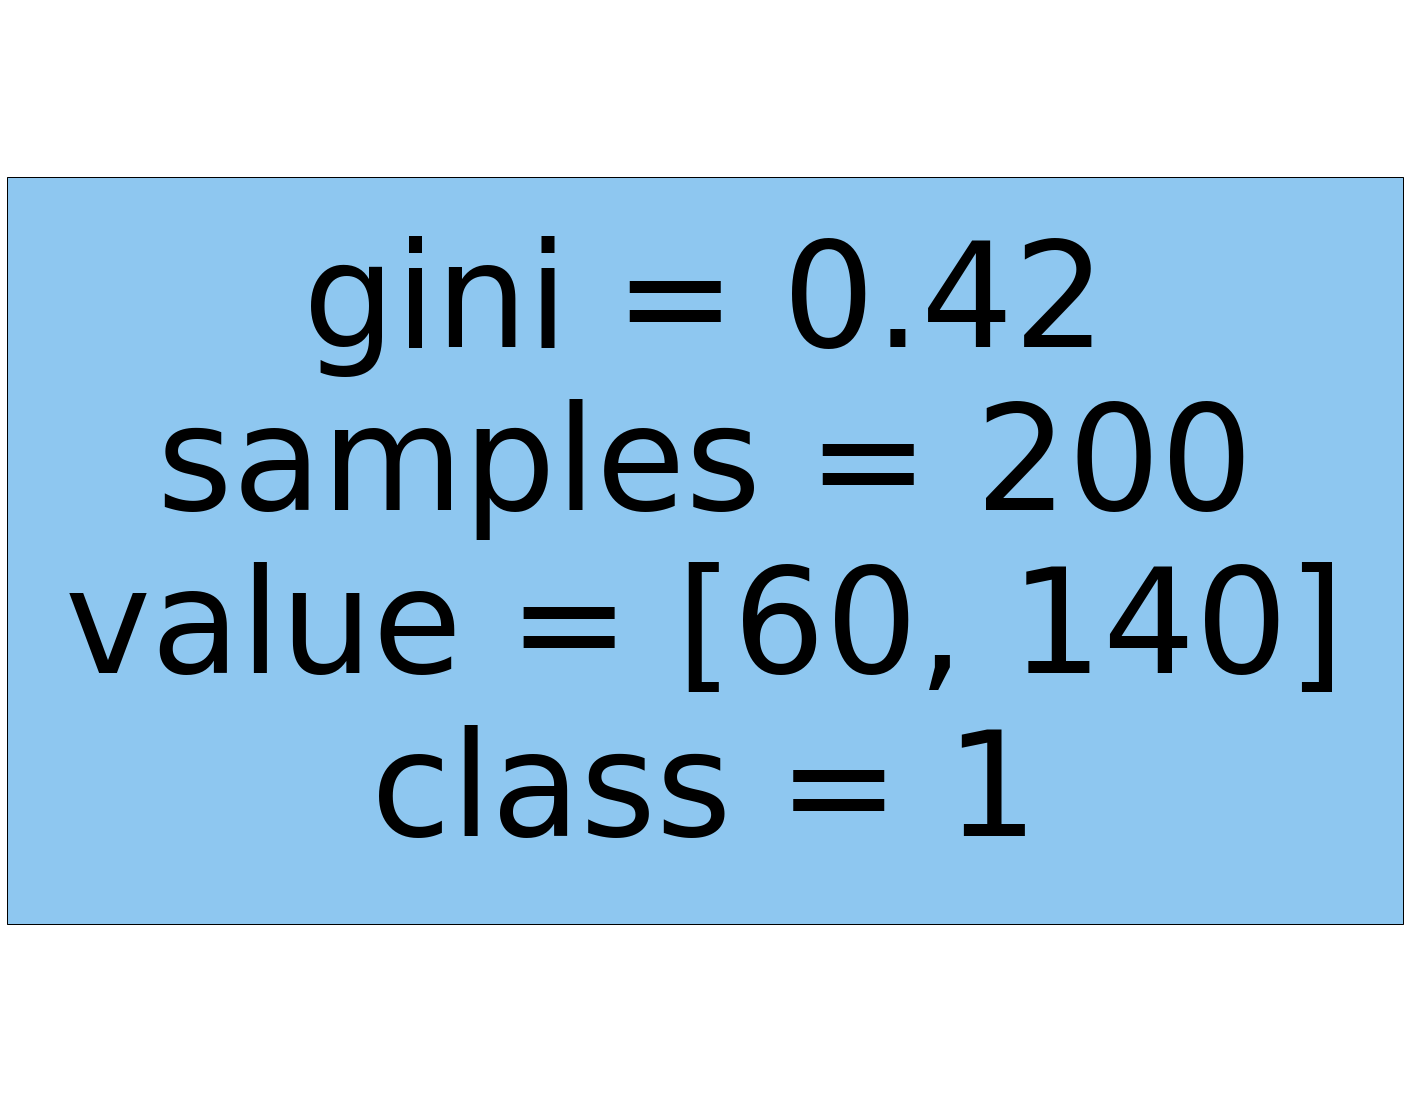

In [124]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(decision_tree_clf['DEAP'], 
                   feature_names=deap_df.columns,  
                   class_names=['0','1'],
                   filled=True)